# FineST in NPC Visium data

## Main steps

- Step1: Prepare paired image patch and ST spot: Align image pixels with spot coordinates
- Step2: Train model oOn within spots: Train the model on 80% data and test on 20% data
- Step3: Infer on between spots: Iinfer gene expression of between spo using trained model
- Step4: Impute on all sub-spots: Impute gene expression using measured gene expression
- Step5: Impute on all single-cells: Impute gene expression using measured gene expression

In [2]:
import os
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import json

# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt
# print("torch version: %s" %torch.__version__)
# print("FineST version: %s" %fst.__version__)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
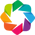

In [3]:
## From GPU2
path = '/mnt/lingyu/nfs_share2/Python/'
os.chdir(str(path) + 'FineST/FineST/')
import FineST as fst
from FineST.datasets import dataset
import FineST.plottings as fstplt

In [5]:
path = '/mnt/lingyu/nfs_share2/Python/'

fst.setup_seed(666)

if torch.cuda.is_available():
    dev = "cuda:2"
else:
    dev = "cpu"
device = torch.device(dev)

colors = ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"]
cnt_color = clr.LinearSegmentedColormap.from_list('magma', colors, N=256)

0.1 Make logging and save model

In [6]:
logging.getLogger().setLevel(logging.INFO)

model_folder = str(path) + 'FineST/FineST_local/Finetune/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

print(dir_name)

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20250210182952620081


0.2 Load parameter settings

You can use the `parameter_file_path` you set or the optimal parameters obtained from your train and test model for your dataset, but here we use our trained `parameter_file_path` for paper results repeated (saved in `FineST/FineST/Parameter/parameters_NPC_P10125.json`).

In [7]:
# parameter_file_path = str(path) + 'FineST/FineST/parameter/parameters_NPC_P10125.json'
parameter_file_path = str(path) + 'FineST/FineST_local/Parameter/parameters_NPC_P10125_virchow2.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2025-02-10 18:29:52] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.25,
  "k_nearest_positives": 0,
  "temperature": 0.03,
  "n_input_image": 1280,
  "w1": 0,
  "w2": 0,
  "w3": 1,
  "w4": 1
}


## 1. Load ST data and Image embeddings

1.1 Load spatial data

A human Nasopharyngeal carcinoma dataset (NPC_patient_1) from [Gong, et al](https://www.nature.com/articles/s41467-023-37614-6). will be used as a reference dataset, raw_feature_bc_matrix, filtered_feature_bc_matrix, and spatial coordinates (.h5) are publicly available in [GSE200310](https://ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200310). For easier reuse, we included them in an anndata object which can be loaded directly in FineST Python package.

In [8]:
adata = dataset.NPC()
print(adata)

AnnData object with n_obs × n_vars = 1331 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.2 Selected LR genes 

In FineST, we only considers 963 human genes involved in ligand-receptor pairs from [CellChatDB (version.1.1.3)](https://github.com/sqjin/CellChat/tree/master/data) (mouse: 2,022 pairs, human: 1,940 pairs, zebrafish: 2,774 pairs), and extract the overlap gene's expression profile.

In [9]:
LR_gene_path = str(path)+'FineST/FineST/Dataset/LRgene/LRgene_CellChatDB_baseline.csv'
adata = fst.adata_LR(adata, LR_gene_path)
print(adata)

AnnData object with n_obs × n_vars = 1331 × 911
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.3 Data preprocess

After making an intersection with the LR genes and filtering out genes that are detected in less than 10 cells, 596 genes from the NPC datasetare used for training and prediction.

In [10]:
adata_count = adata.copy()
adata = fst.adata_preprocess(adata_count, keep_raw=True, normalize=False)
print(adata)

gene_hv = np.array(adata.var_names)
matrix = fst.adata2matrix(adata, gene_hv)
matrix

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
(1331, 596)


TGFB1  TGFBR1  TGFBR2  TGFB2  TGFB3  ACVR1B  ACVR1C  \
                                                                          
AAACAATCTACTAGCA-1    0.0     0.0     0.0    0.0    1.0     1.0     0.0   
AAACGAAGAACATACC-1    3.0     0.0     0.0    0.0    0.0     0.0     0.0   
AAAGGGATGTAGCAAG-1    0.0     1.0     0.0    0.0    0.0     1.0     0.0   
AAAGTCACTGATGTAA-1    0.0     1.0     0.0    0.0    0.0     2.0     0.0   
AAAGTGTGATTTATCT-1    1.0     0.0     3.0    0.0    0.0     0.0     0.0   
...                   ...     ...     ...    ...    ...     ...     ...   
TTGTGGCCCTGACAGT-1    0.0     0.0     0.0    0.0    0.0     0.0     0.0   
TTGTGTTTCCCGAAAG-1    2.0     0.0     0.0    0.0    0.0     0.0     0.0   
TTGTTAGCAAATTCGA-1    1.0     1.0     0.0    0.0    0.0     1.0     0.0   
TTGTTCAGTGTGCTAC-1    1.0     0.0     0.0    0.0    0.0     0.0     0.0   
TTGTTTGTGTAAATTC-1    1.0     0.0     0.0    0.0    0.0     1.0     0.0   

                    ACVR1  BMP2  BMPR1A  ...  KDR  TREM2  SEMA6A  SEMA6B  \
                                         ...                               
AAACAATCTACTAGCA-1    0.0   0.0     0.0  ...  0.0    1.0     0.0     0.0   
AAACGAAGAACATACC-1    1.0   0.0     0.0  ...  0.0    0.0     1.0     0.0   
AAAGGGATGTAGCAAG-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
AAAGTCACTGATGTAA-1    0.0   0.0     0.0  ...  0.0    0.0     1.0     0.0   
AAAGTGTGATTTATCT-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
...                   ...   ...     ...  ...  ...    ...     ...     ...   
TTGTGGCCCTGACAGT-1    1.0   0.0     1.0  ...  0.0    0.0     0.0     0.0   
TTGTGTTTCCCGAAAG-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
TTGTTAGCAAATTCGA-1    1.0   1.0     0.0  ...  0.0    0.0     1.0     0.0   
TTGTTCAGTGTGCTAC-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
TTGTTTGTGTAAATTC-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   

                    SEMA7A  PLXNC1  SIGLEC1  THY1  VCAM1  VSIR  
                                                                
AAACAATCTACTAGCA-1     0.0     0.0      0.0   0.0    0.0   0.0  
AAACGAAGAACATACC-1     0.0     0.0      1.0   0.0    2.0   0.0  
AAAGGGATGTAGCAAG-1     0.0     0.0      0.0   1.0    5.0   1.0  
AAAGTCACTGATGTAA-1     0.0     0.0      1.0   0.0    4.0   1.0  
AAAGTGTGATTTATCT-1     0.0     0.0      0.0   0.0    1.0   2.0  
...                    ...     ...      ...   ...    ...   ...  
TTGTGGCCCTGACAGT-1     1.0     0.0      0.0   0.0    1.0   1.0  
TTGTGTTTCCCGAAAG-1     1.0     1.0      0.0   1.0    1.0   2.0  
TTGTTAGCAAATTCGA-1     0.0     0.0      0.0   0.0    6.0   1.0  
TTGTTCAGTGTGCTAC-1     0.0     0.0      0.0   0.0    2.0   0.0  
TTGTTTGTGTAAATTC-1     0.0     0.0      0.0   0.0    1.0   2.0  

[1331 rows x 596 columns]

1.4 Order by image file name

Load image embedding from **Setp0** `HIPT_image_feature_extract.py`. For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo) (within spots: AH_Patient1_pth_64_16, between spots: NEW_AH_Patient1_pth_64_16, single-nuclei: sc_Patient1_pth_16_16).

In [11]:
# file_paths = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/'))
# file_paths = sorted(os.listdir(str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_56_14/'))
file_paths = sorted(os.listdir(str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_112_14/'))
print("Image embedding file (first three .pth):\n", file_paths[:3])

Image embedding file (first three .pth):
 ['AH_Patient1_10014_10023.pth', 'AH_Patient1_10015_9649.pth', 'AH_Patient1_10016_9276.pth']


In [12]:
## Image patch position
position_image = fst.get_image_coord(file_paths, dataset_class="Visium")
print("The coords of image patch: \n",position_image.shape)
print(position_image.head())

The coords of image patch: 
 (1331, 2)
   pixel_x  pixel_y
0    10023    10014
1     9649    10015
2     9276    10016
3     7783    10020
4     7410    10021


In [13]:
## ST spot position
os.chdir(str(path)+'FineST/FineST/Dataset/NPC/patient1/')
position = pd.read_csv('tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', 
                                    position.columns[-1]: 'pixel_y'})
print("The coords of ST spot: \n", position.shape)
print(position.head())

The coords of ST spot: 
 (4992, 6)
                    0  1  2  3  pixel_x  pixel_y
0  ACGCCTGACACGCGCT-1  0  0  0     1416     1884
1  TACCGATCCAACACTT-1  0  1  1     1603     1991
2  ATTAAAGCGGACGAGC-1  0  0  2     1417     2098
3  GATAAGGGACGATTAG-1  0  1  3     1604     2205
4  GTGCAAATCACCAATA-1  0  0  4     1417     2313


In [14]:
## merge position
position_image = fst.image_coord_merge(position_image, position, dataset_class = 'Visium')
position_order = fst.update_st_coord(position_image)
print("The coords of image patch (merged): \n", position_order.shape)
print(position_order.head())

The coords of image patch (merged): 
 (1331, 4)
   pixel_y  pixel_x  array_row  array_col
0    10014    10023         76         46
1    10015     9649         76         44
2    10016     9276         76         42
3    10020     7783         76         34
4    10021     7410         76         32


In [15]:
print(position_order['pixel_y'].max(), position_order['pixel_x'].max())

13236 11328


In [16]:
## save the position data  -- train model used
position_order.to_csv(str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order.csv', index=False, header=False)

1.5 Order matrix row/barcode, spatial coordinates by image coordinates

In [17]:
spotID_order = np.array(position_image[0])
matrix_order, matrix_order_df = fst.sort_matrix(matrix, position_image, spotID_order, gene_hv)
matrix_order_df

TGFB1  TGFBR1  TGFBR2  TGFB2  TGFB3  ACVR1B  ACVR1C  \
GTCGTTATTCGCTTAT-1    0.0     0.0     0.0    0.0    0.0     0.0     0.0   
ACAAGGGCAGGCTCTG-1    5.0     2.0     2.0    0.0    0.0     0.0     0.0   
TGCGTTTGTTGACACT-1    0.0     0.0     1.0    0.0    0.0     1.0     0.0   
TTGAATATGGACTTTC-1    1.0     1.0     2.0    0.0    1.0     0.0     0.0   
CCGGGCGGTCTCGTCA-1    0.0     0.0     0.0    0.0    0.0     0.0     0.0   
...                   ...     ...     ...    ...    ...     ...     ...   
CCTCTGGCCTAGACGG-1    0.0     0.0     0.0    0.0    0.0     1.0     0.0   
CAAACTATTGAGCTTC-1    1.0     0.0     0.0    0.0    0.0     1.0     0.0   
ACATCGTTAACCTAGT-1    1.0     0.0     0.0    0.0    0.0     0.0     0.0   
GTTAGAGTGTGCCGCT-1    0.0     0.0     0.0    0.0    0.0     0.0     0.0   
TCAGTTACGGAATGAT-1    1.0     0.0     0.0    0.0    0.0     0.0     0.0   

                    ACVR1  BMP2  BMPR1A  ...  KDR  TREM2  SEMA6A  SEMA6B  \
GTCGTTATTCGCTTAT-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
ACAAGGGCAGGCTCTG-1    0.0   1.0     0.0  ...  0.0    0.0     0.0     1.0   
TGCGTTTGTTGACACT-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
TTGAATATGGACTTTC-1    1.0   0.0     1.0  ...  0.0    0.0     0.0     0.0   
CCGGGCGGTCTCGTCA-1    0.0   0.0     0.0  ...  0.0    0.0     0.0     0.0   
...                   ...   ...     ...  ...  ...    ...     ...     ...   
CCTCTGGCCTAGACGG-1    0.0   0.0     0.0  ...  0.0    0.0     1.0     0.0   
CAAACTATTGAGCTTC-1    0.0   0.0     0.0  ...  0.0    1.0     0.0     0.0   
ACATCGTTAACCTAGT-1    0.0   0.0     1.0  ...  0.0    0.0     0.0     0.0   
GTTAGAGTGTGCCGCT-1    0.0   0.0     0.0  ...  0.0    0.0     2.0     0.0   
TCAGTTACGGAATGAT-1    1.0   0.0     0.0  ...  0.0    0.0     1.0     0.0   

                    SEMA7A  PLXNC1  SIGLEC1  THY1  VCAM1  VSIR  
GTCGTTATTCGCTTAT-1     1.0     0.0      0.0   1.0    0.0   0.0  
ACAAGGGCAGGCTCTG-1     1.0     0.0      0.0   2.0    5.0   1.0  
TGCGTTTGTTGACACT-1     0.0     0.0      0.0   0.0    0.0   0.0  
TTGAATATGGACTTTC-1     0.0     0.0      0.0   2.0    3.0   0.0  
CCGGGCGGTCTCGTCA-1     0.0     0.0      0.0   1.0    1.0   0.0  
...                    ...     ...      ...   ...    ...   ...  
CCTCTGGCCTAGACGG-1     0.0     0.0      0.0   0.0    3.0   1.0  
CAAACTATTGAGCTTC-1     0.0     0.0      0.0   0.0    0.0   0.0  
ACATCGTTAACCTAGT-1     0.0     0.0      0.0   1.0    2.0   2.0  
GTTAGAGTGTGCCGCT-1     0.0     0.0      0.0   0.0    3.0   0.0  
TCAGTTACGGAATGAT-1     0.0     0.0      0.0   0.0    3.0   0.0  

[1331 rows x 596 columns]

In [18]:
## save gene expression mateix -- train model used
np.save(str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy', matrix_order_df.T)

1.6 Update adata with new barcodes and lications

In [19]:
## adata - count
adata = fst.update_adata_coord(adata, matrix_order_df, position_image)
print(adata)
print(adata.obsm['spatial'])

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
[[10014 10023]
 [10015  9649]
 [10016  9276]
 ...
 [ 9924  3117]
 [ 9925  2743]
 [ 9927  1997]]


In [20]:
## adata - normalized
adata_count = adata.copy()
adata_norma = fst.adata_preprocess(adata_count, keep_raw=True, normalize=True)
print(adata_norma)
adata_norma.to_df().head()

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


TGFB1    TGFBR1    TGFBR2  TGFB2     TGFB3    ACVR1B  \
GTCGTTATTCGCTTAT-1  0.000000  0.000000  0.000000    0.0  0.000000  0.000000   
ACAAGGGCAGGCTCTG-1  1.543805  0.905412  0.905412    0.0  0.000000  0.000000   
TGCGTTTGTTGACACT-1  0.000000  0.000000  1.092333    0.0  0.000000  1.092333   
TTGAATATGGACTTTC-1  0.418937  0.418937  0.713288    0.0  0.418937  0.000000   
CCGGGCGGTCTCGTCA-1  0.000000  0.000000  0.000000    0.0  0.000000  0.000000   

                    ACVR1C     ACVR1      BMP2    BMPR1A  ...  KDR  TREM2  \
GTCGTTATTCGCTTAT-1     0.0  0.000000  0.000000  0.000000  ...  0.0    0.0   
ACAAGGGCAGGCTCTG-1     0.0  0.000000  0.551857  0.000000  ...  0.0    0.0   
TGCGTTTGTTGACACT-1     0.0  0.000000  0.000000  0.000000  ...  0.0    0.0   
TTGAATATGGACTTTC-1     0.0  0.418937  0.000000  0.418937  ...  0.0    0.0   
CCGGGCGGTCTCGTCA-1     0.0  0.000000  0.000000  0.000000  ...  0.0    0.0   

                    SEMA6A    SEMA6B    SEMA7A  PLXNC1  SIGLEC1      THY1  \
GTCGTTATTCGCTTAT-1     0.0  0.000000  1.463911     0.0      0.0  1.463911   
ACAAGGGCAGGCTCTG-1     0.0  0.551857  0.551857     0.0      0.0  0.905412   
TGCGTTTGTTGACACT-1     0.0  0.000000  0.000000     0.0      0.0  0.000000   
TTGAATATGGACTTTC-1     0.0  0.000000  0.000000     0.0      0.0  0.713288   
CCGGGCGGTCTCGTCA-1     0.0  0.000000  0.000000     0.0      0.0  0.848202   

                       VCAM1      VSIR  
GTCGTTATTCGCTTAT-1  0.000000  0.000000  
ACAAGGGCAGGCTCTG-1  1.543805  0.551857  
TGCGTTTGTTGACACT-1  0.000000  0.000000  
TTGAATATGGACTTTC-1  0.940412  0.000000  
CCGGGCGGTCTCGTCA-1  0.848202  0.000000  

[5 rows x 596 columns]

In [21]:
## save the original adata
patientxy = 'patient1'
adata_count.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_count.h5ad')
adata_norma.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_norma.h5ad')

<div class="alert alert-info">

**Note**
The above cells for `section 1.5` only need to be run once. They aim to generate the ordered gene expression profile `harmony_matrix.npy` and the ordered ST spot coordinates `position_order.csv` according to image pixel coordinates, and save the normalized gene expression data `patient1_adata_orignal`. 

</div>

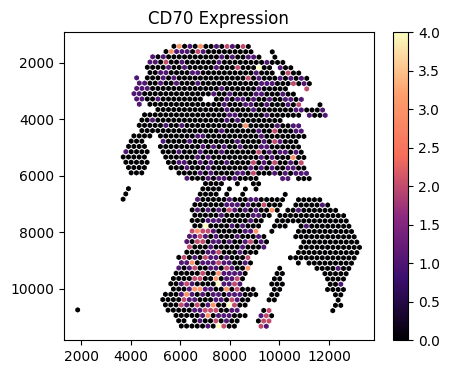

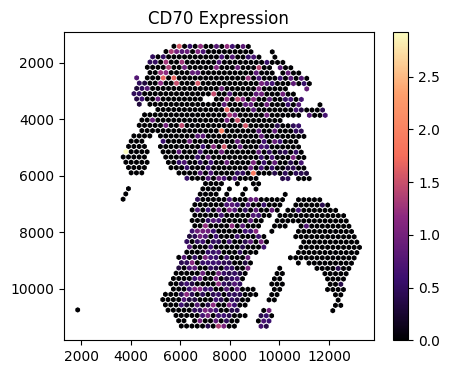

In [22]:
# fstplt.gene_expr(adata_count, matrix_order_df, gene_selet='CD70', marker='h', s=8, figsize=(5, 4), save_path=None)
fstplt.gene_expr(adata_count, adata_count.to_df(), gene_selet='CD70', marker='h', s=8, figsize=(5, 4), save_path=None)
fstplt.gene_expr(adata_norma, adata_norma.to_df(), gene_selet='CD70', marker='h', s=8, figsize=(5, 4), save_path=None)

## 2 Train and Test model

2.1 Data loader and splitting: 80% for train and 20% for test

Input: three input file pathway: \
    - `image_embed_path`: image embedding from **Setp0** `HIPT_image_feature_extract.py` \
    - `spatial_pos_path`: ordered ST spot coords, in `./Dataset/NPC/ContrastP1geneLR/position_order.csv` \
    - `reduced_mtx_path`: ordered gene expression, in `./Dataset/NPC/ContrastP1geneLR/harmony_matrix.np` 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [24]:
# image_embed_path_NPC = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth'    
# image_embed_path_NPC = str(path)+'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_56_14/*.pth' 
image_embed_path_NPC = str(path)+'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_112_14/*.pth' 
spatial_pos_path = str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order.csv'
reduced_mtx_path = str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy'

2.2 Train and test model on within spot

In [24]:
## add params
params['n_input_matrix'] = len(gene_hv)

## init the model
model = fst.FineSTModel(n_input_matrix=params['n_input_matrix'],
                              n_input_image=params['n_input_image'],
                              n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
                              n_encoder_hidden_image=params["n_encoder_hidden_image"],
                              n_encoder_latent=params["n_encoder_latent"],
                              n_projection_hidden=params["n_projection_hidden"],
                              n_projection_output=params["n_projection_output"],
                              n_encoder_layers=params["n_encoder_layers"]).to(device) 
## Load the data
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path_NPC, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              image_clacss='Virchow2',
                                              dataset_class='Visium64') 
## Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], 
                            momentum=0.9, weight_decay=5e-4)
## Load loss function
l = fst.ContrastiveLoss(temperature=params['temperature'], 
                        w1=params['w1'], w2=params['w2'], w3=params['w3'], w4=params['w4'])

## train model
(dir_name, 
 train_losses, test_losses, 
 best_epoch, best_loss) = fst.train_model_fst(params, model, train_loader, test_loader, 
                                          optimizer, l, dir_name, logger, dataset_class='Visium64')

Finished loading all files
train/test split completed
1064 267
***** Finished building loaders *****


[2025-02-06 08:28:43] INFO - Begin Training ...
[2025-02-06 08:28:43] INFO - epoch [1/50]


Epoch: 1
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.696515560150146 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.76it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:28:52] INFO - Saved Best epoch & Best Model! Loss: [0: 1.716474970181783]
[2025-02-06 08:28:52] INFO - epoch [2/50]


Saved Best epoch & Best Model! Loss: [0: 1.716474970181783]
Epoch: 2
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.82it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.100016832351685 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.06it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:01] INFO - Saved Best epoch & Best Model! Loss: [1: 1.6198556224505107]
[2025-02-06 08:29:01] INFO - epoch [3/50]


Saved Best epoch & Best Model! Loss: [1: 1.6198556224505107]
Epoch: 3
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.66it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.090337753295898 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:09] INFO - Saved Best epoch & Best Model! Loss: [2: 1.5967705845832825]
[2025-02-06 08:29:09] INFO - epoch [4/50]


Saved Best epoch & Best Model! Loss: [2: 1.5967705845832825]
Epoch: 4
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.70it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.082689046859741 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.09it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:17] INFO - epoch [5/50]


Epoch: 5
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.24it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.9998390674591064 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.00it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:26] INFO - Saved Best epoch & Best Model! Loss: [4: 1.5838205416997273]
[2025-02-06 08:29:26] INFO - epoch [6/50]


Saved Best epoch & Best Model! Loss: [4: 1.5838205416997273]
Epoch: 6
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.84it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.09190821647644 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.53it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:34] INFO - Saved Best epoch & Best Model! Loss: [5: 1.5352877378463745]
[2025-02-06 08:29:34] INFO - epoch [7/50]


Saved Best epoch & Best Model! Loss: [5: 1.5352877378463745]
Epoch: 7
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 85.91it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.065258979797363 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.03it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:43] INFO - Saved Best epoch & Best Model! Loss: [6: 1.4969556331634521]
[2025-02-06 08:29:43] INFO - epoch [8/50]


Saved Best epoch & Best Model! Loss: [6: 1.4969556331634521]
Epoch: 8
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.87it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.012213945388794 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.91it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:29:51] INFO - Saved Best epoch & Best Model! Loss: [7: 1.4917337894439697]
[2025-02-06 08:29:51] INFO - epoch [9/50]


Saved Best epoch & Best Model! Loss: [7: 1.4917337894439697]
Epoch: 9
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.95it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.950674295425415 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.02it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:00] INFO - Saved Best epoch & Best Model! Loss: [8: 1.4759647051493328]
[2025-02-06 08:30:00] INFO - epoch [10/50]


Saved Best epoch & Best Model! Loss: [8: 1.4759647051493328]
Epoch: 10
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.73it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.969712018966675 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.91it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:08] INFO - epoch [11/50]


Epoch: 11
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.46it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.039566040039062 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.87it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:16] INFO - Saved Best epoch & Best Model! Loss: [10: 1.4645548065503438]
[2025-02-06 08:30:16] INFO - epoch [12/50]


Saved Best epoch & Best Model! Loss: [10: 1.4645548065503438]
Epoch: 12
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.27it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.962949752807617 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.80it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:25] INFO - Saved Best epoch & Best Model! Loss: [11: 1.4542072415351868]
[2025-02-06 08:30:25] INFO - epoch [13/50]


Saved Best epoch & Best Model! Loss: [11: 1.4542072415351868]
Epoch: 13
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 97.06it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.966026067733765 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.64it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:33] INFO - Saved Best epoch & Best Model! Loss: [12: 1.4498387177785237]
[2025-02-06 08:30:33] INFO - epoch [14/50]


Saved Best epoch & Best Model! Loss: [12: 1.4498387177785237]
Epoch: 14
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.03it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.010468006134033 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.19it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:42] INFO - Saved Best epoch & Best Model! Loss: [13: 1.447014609972636]
[2025-02-06 08:30:42] INFO - epoch [15/50]


Saved Best epoch & Best Model! Loss: [13: 1.447014609972636]
Epoch: 15
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.60it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.033943891525269 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.79it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:50] INFO - Saved Best epoch & Best Model! Loss: [14: 1.4270024696985881]
[2025-02-06 08:30:50] INFO - epoch [16/50]


Saved Best epoch & Best Model! Loss: [14: 1.4270024696985881]
Epoch: 16
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.00it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.942291021347046 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.31it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:30:58] INFO - Saved Best epoch & Best Model! Loss: [15: 1.4194937348365784]
[2025-02-06 08:30:58] INFO - epoch [17/50]


Saved Best epoch & Best Model! Loss: [15: 1.4194937348365784]
Epoch: 17
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.47it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.024747848510742 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.58it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:07] INFO - epoch [18/50]


Epoch: 18
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.39it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.014131307601929 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.23it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:15] INFO - Saved Best epoch & Best Model! Loss: [17: 1.409116804599762]
[2025-02-06 08:31:15] INFO - epoch [19/50]


Saved Best epoch & Best Model! Loss: [17: 1.409116804599762]
Epoch: 19
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.89it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.959036827087402 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.42it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:24] INFO - epoch [20/50]


Epoch: 20
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.71it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.966443777084351 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.96it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:32] INFO - epoch [21/50]


Epoch: 21
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.57it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.288330554962158 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.38it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:41] INFO - Saved Best epoch & Best Model! Loss: [20: 1.4006074666976929]
[2025-02-06 08:31:41] INFO - epoch [22/50]


Saved Best epoch & Best Model! Loss: [20: 1.4006074666976929]
Epoch: 22
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 83.68it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.014153003692627 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.13it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:49] INFO - Saved Best epoch & Best Model! Loss: [21: 1.3957984447479248]
[2025-02-06 08:31:49] INFO - epoch [23/50]


Saved Best epoch & Best Model! Loss: [21: 1.3957984447479248]
Epoch: 23
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.56it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.032590866088867 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.21it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:31:58] INFO - epoch [24/50]


Epoch: 24
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.79it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.992031097412109 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:06] INFO - Saved Best epoch & Best Model! Loss: [23: 1.3858490784962971]
[2025-02-06 08:32:06] INFO - epoch [25/50]


Saved Best epoch & Best Model! Loss: [23: 1.3858490784962971]
Epoch: 25
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.85it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.962426662445068 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.46it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:14] INFO - epoch [26/50]


Epoch: 26
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.52it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.013840675354004 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.04it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:23] INFO - epoch [27/50]


Epoch: 27
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.11it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.020964860916138 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.09it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:31] INFO - epoch [28/50]


Epoch: 28
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.10it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.027159452438354 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.16it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:40] INFO - epoch [29/50]


Epoch: 29
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.98it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.021801233291626 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.46it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:48] INFO - epoch [30/50]


Epoch: 30
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.75it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.032217264175415 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.86it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:32:56] INFO - Saved Best epoch & Best Model! Loss: [29: 1.3815899292627971]
[2025-02-06 08:32:56] INFO - epoch [31/50]


Saved Best epoch & Best Model! Loss: [29: 1.3815899292627971]
Epoch: 31
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 85.38it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.960273504257202 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.98it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:05] INFO - Saved Best epoch & Best Model! Loss: [30: 1.3763663570086162]
[2025-02-06 08:33:05] INFO - epoch [32/50]


Saved Best epoch & Best Model! Loss: [30: 1.3763663570086162]
Epoch: 32
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.98it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.009329557418823 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.96it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:13] INFO - epoch [33/50]


Epoch: 33
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.23it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.001947164535522 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.84it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:21] INFO - epoch [34/50]


Epoch: 34
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.83it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.043178081512451 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.77it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:30] INFO - epoch [35/50]


Epoch: 35
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.30it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.941359281539917 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.35it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:38] INFO - epoch [36/50]


Epoch: 36
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.59it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.9877684116363525 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.39it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:47] INFO - epoch [37/50]


Epoch: 37
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.34it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.020078897476196 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.77it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:33:55] INFO - epoch [38/50]


Epoch: 38
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.20it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.096405506134033 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.81it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:04] INFO - epoch [39/50]


Epoch: 39
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.98it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.120733261108398 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.08it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:12] INFO - epoch [40/50]


Epoch: 40
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86.07it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.071479558944702 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.08it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:20] INFO - epoch [41/50]


Epoch: 41
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.90it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 7.999758243560791 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.53it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:29] INFO - Saved Best epoch & Best Model! Loss: [40: 1.37581205368042]
[2025-02-06 08:34:29] INFO - epoch [42/50]


Saved Best epoch & Best Model! Loss: [40: 1.37581205368042]
Epoch: 42
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.33it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 7.9742958545684814 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.64it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:37] INFO - Saved Best epoch & Best Model! Loss: [41: 1.3737712502479553]
[2025-02-06 08:34:37] INFO - epoch [43/50]


Saved Best epoch & Best Model! Loss: [41: 1.3737712502479553]
Epoch: 43
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.06it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.120940685272217 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.54it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:46] INFO - epoch [44/50]


Epoch: 44
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.94it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.213946104049683 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.56it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:34:54] INFO - Saved Best epoch & Best Model! Loss: [43: 1.3737016717592876]
[2025-02-06 08:34:54] INFO - epoch [45/50]


Saved Best epoch & Best Model! Loss: [43: 1.3737016717592876]
Epoch: 45
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.22it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.033752918243408 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.95it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:35:03] INFO - Saved Best epoch & Best Model! Loss: [44: 1.3711345195770264]
[2025-02-06 08:35:03] INFO - epoch [46/50]


Saved Best epoch & Best Model! Loss: [44: 1.3711345195770264]
Epoch: 46
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.87it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.05994725227356 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.39it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:35:11] INFO - epoch [47/50]


Epoch: 47
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.39it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.139724254608154 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.09it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:35:20] INFO - epoch [48/50]


Epoch: 48
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 90.14it/s]


image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............
--- 8.060869455337524 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.20it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:35:28] INFO - Saved Best epoch & Best Model! Loss: [47: 1.370915671189626]
[2025-02-06 08:35:28] INFO - epoch [49/50]


Saved Best epoch & Best Model! Loss: [47: 1.370915671189626]
Epoch: 49
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.37it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.051701784133911 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.59it/s]
[2025-02-06 08:35:36] INFO - epoch [50/50]


image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............
Epoch: 50
train model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.58it/s]

image_tensor: torch.Size([1000, 64, 1280])
checkNeighbors.............


--- 8.104116678237915 seconds ---
test model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.89it/s]

image_tensor: torch.Size([200, 64, 1280])
checkNeighbors.............



[2025-02-06 08:35:45] INFO - Saved Best epoch & Best Model! Loss: [49: 1.3695866862932842]
[2025-02-06 08:35:45] INFO - Done!, Best epoch & Best Model! Loss: [49: 1.3695866862932842]
[2025-02-06 08:35:45] INFO - Finished Training


Saved Best epoch & Best Model! Loss: [49: 1.3695866862932842]
Done!, final loss: 1.3695866862932842
Best epoch: 49
--- 422.0597491264343 seconds ---


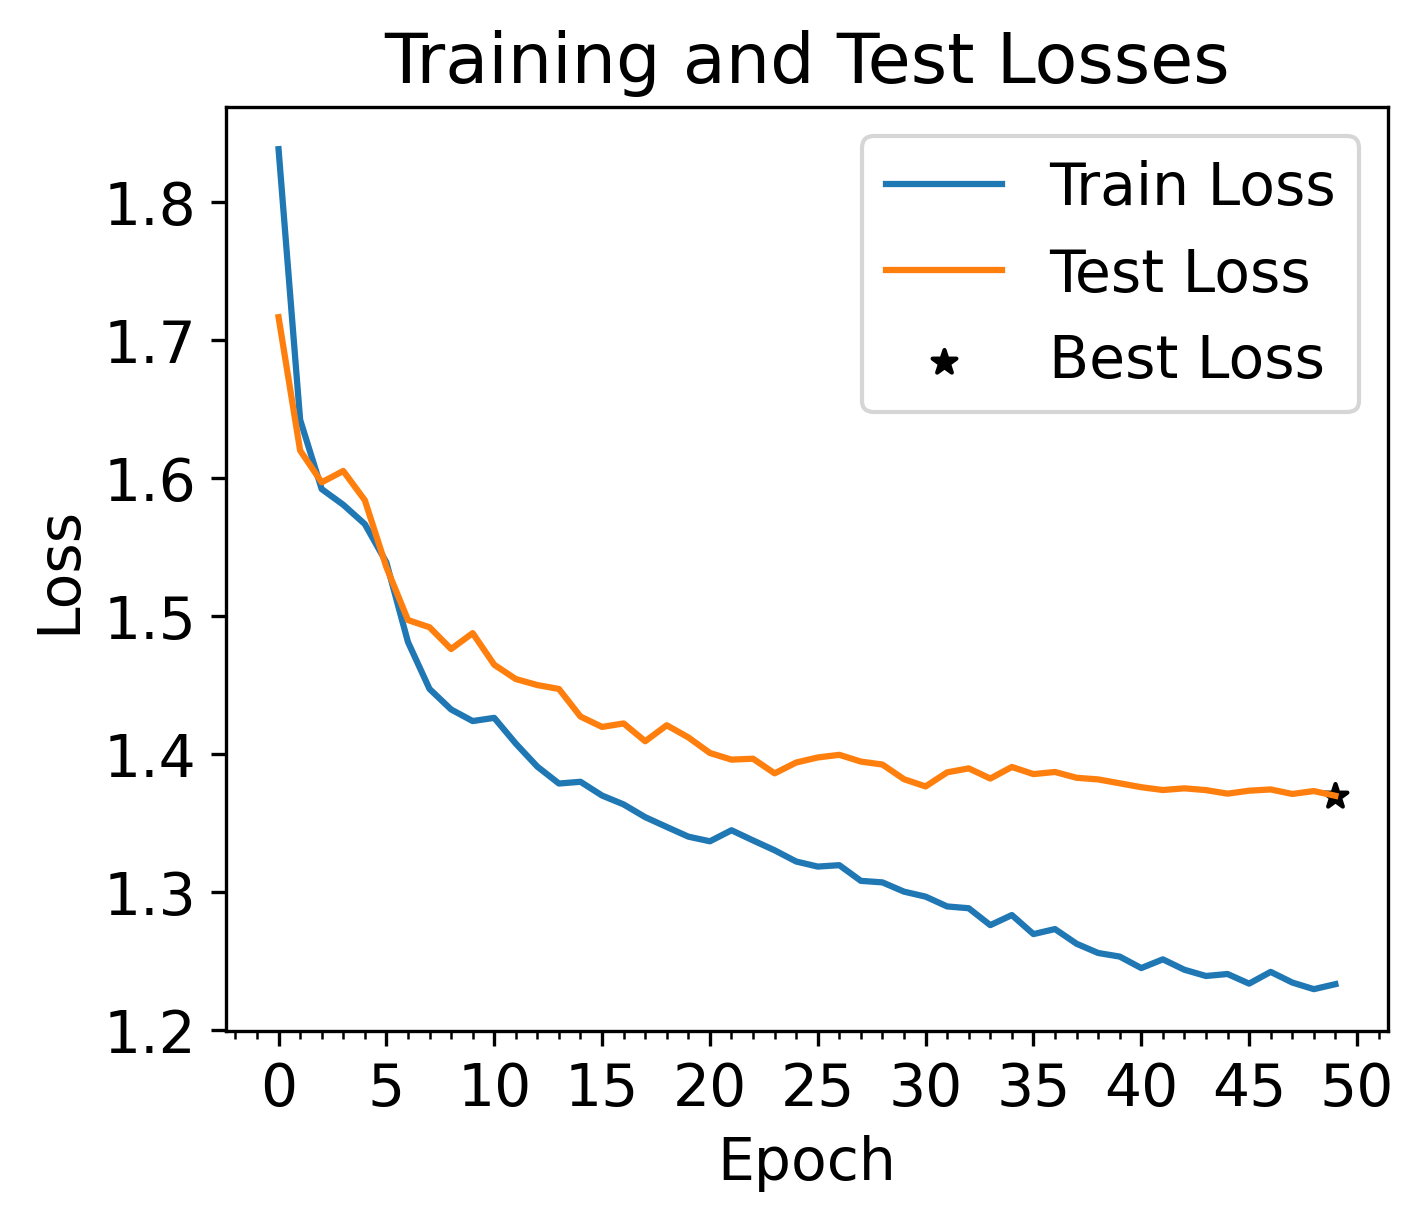

In [45]:
fst.loss_curve(train_losses, test_losses, best_epoch, best_loss, max_step=5, min_step=1, 
               fig_size=(5, 4), format='svg', save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/NPC_loss_curve.svg')

<div class="alert alert-info">

**Note**
The above cell for `section 2.2` needs to be run more than once by setting different parameters in the given `.json` file, if the correlation in `section 3.4` is not satisfying. If one obtains a good performance, one can save the `dir_name` and then directly use it to load the trained model and infer gene expression, and doesn't need to run `section 2.2` again. Recommended parameter fine-tuning and its range: `training_epoch`: 40~60; 
`temperature`: 0.01-0.05.

</div>

## 3. Inference, Imputation and Evaluation on within spot

3.1 Infer the gene expression of within spots

In [27]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20250206082837029647'

You can use the `dir_name` just obtained from the above cell, but here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20250206082837029647`).

In [25]:
# dir_name = str(path)+'FineST/FineST_local/Finetune/20250206082837029647'

In [26]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)

## Load test data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path_NPC, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          image_clacss='Virchow2',
                                          dataset_class='Visium64')
## Inference
(matrix_profile,
 reconstructed_matrix, 
 recon_ref_adata_image_f2, 
 reconstructed_matrix_reshaped, 
 input_coord_all) = fst.infer_model_fst(model, test_loader, logger, dataset_class='Visium64')

[2025-02-10 18:30:00] INFO - Running inference task...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:2
***** Begin perform_inference: ******


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]

***** batch_size=adata.shape[0] doen't effect *****
torch.Size([1331, 596])
torch.Size([1331, 64, 1280])
1
1
1
***** *****
Finished extractting test data



[2025-02-10 18:30:01] INFO - Running inference task DONE!


--- 0.7873406410217285 seconds for inference within spots ---
Reconstructed_matrix_reshaped shape:  torch.Size([85184, 596])


In [27]:
print(matrix_profile)
print(reconstructed_matrix)
print(recon_ref_adata_image_f2)
print(input_coord_all)

[[0. 0. 0. ... 1. 0. 0.]
 [5. 2. 2. ... 2. 5. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 2. 2.]
 [0. 0. 0. ... 0. 3. 0.]
 [1. 0. 0. ... 0. 3. 0.]]
[[0.03893156 0.01322763 0.03786816 ... 0.00985889 0.05814403 0.04896163]
 [0.161494   0.10569012 0.15358353 ... 0.110282   0.18101807 0.15037882]
 [0.02061014 0.01694734 0.00996974 ... 0.00991729 0.09824407 0.07530727]
 ...
 [0.1298941  0.08256104 0.07117878 ... 0.17605814 0.18741135 0.13442889]
 [0.07651875 0.10009959 0.00887011 ... 0.06576475 0.36121482 0.05526736]
 [0.06140848 0.09702538 0.0093874  ... 0.06979671 0.4294809  0.08768886]]
[[0.07047851 0.06511056 0.00596048 ... 0.07803563 0.20155308 0.10882005]
 [0.05555908 0.06403521 0.00533229 ... 0.07423974 0.19771194 0.08614344]
 [0.02017457 0.02302887 0.00249322 ... 0.02304707 0.06985416 0.03272102]
 ...
 [0.02797972 0.01761279 0.00235765 ... 0.03660507 0.14874889 0.05349658]
 [0.03526741 0.02306705 0.00265141 ... 0.03474563 0.19711003 0.06406881]
 [0.02066008 0.01805682 0.0024

3.2 Get coordinates of sub-spots from within spots

We use `reshape_latent_image()` function to convert the super-resolved gene expression with 16X relolution `reconstructed_matrix_reshaped` (torch.Size([21296, 596])) into tensor format `reconstructed_matrix_reshaped_tensor` (torch.Size([1331, 16, 596])).

In [28]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
print("The size of reconstructed tensor data:", reconstructed_matrix_reshaped_tensor.shape)

The size of reconstructed tensor data: torch.Size([1331, 64, 596])


In [29]:
scale_factors = fst.json_load(f"{path}/FineST/FineST_local/Dataset/NPC/patient1/")
print(scale_factors['spot_diameter_fullres'])

139.44595843130838


In [30]:
(first_spot_first_variable, C,
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, adata, gene_hv, 
                                         p=0, q=0, patch_size=112, dataset_class='Visium64')
print("first_spot_first_variable shape:", first_spot_first_variable.shape)

pixel_step (half of patch_size): 7.0
first_spot_first_variable shape: (64,)


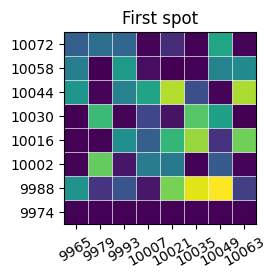

In [32]:
fstplt.subspot_expr(C, first_spot_first_variable, patch_size=112, dataset_class='Visium64', 
                     marker='s', s=250, rotation=30, save_path=None)

In [34]:
## Get the sub-spot level gene expression of all genes in all within spots
(_, _, all_spot_all_variable,
 C2, adata_infer) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                adata, gene_hv, patch_size=112, dataset_class='Visium64')
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer)

pixel_step (half of patch_size): 7.0
all_spot_all_variable shape: (85184, 596)
AnnData object with n_obs × n_vars = 85184 × 596
    obs: 'x', 'y'
    obsm: 'spatial'


In [35]:
print(adata_infer.obs[['x', 'y']])
print(adata_infer.obsm['spatial'])
print(adata_infer.obsm['spatial'][:,0].max(), adata_infer.obsm['spatial'][:,1].max())

           x     y
0       9965  9974
1       9979  9974
2       9993  9974
3      10007  9974
4      10021  9974
...      ...   ...
85179   9920  2046
85180   9934  2046
85181   9948  2046
85182   9962  2046
85183   9976  2046

[85184 rows x 2 columns]
[[9965 9974]
 [9979 9974]
 [9993 9974]
 ...
 [9948 2046]
 [9962 2046]
 [9976 2046]]
13285 11377


Here, `adata_infer` is the inferred super-resolved gene expression data with 16X solution.

In [36]:
_, adata_infer_reshape = fst.reshape_latent_image(torch.tensor(adata_infer.X), dataset_class='Visium64')
print("adata_infer shape:", adata_infer.shape)
print("adata_infer_reshape shape:", adata_infer_reshape.shape)

adata_infer shape: (85184, 596)
adata_infer_reshape shape: torch.Size([1331, 596])


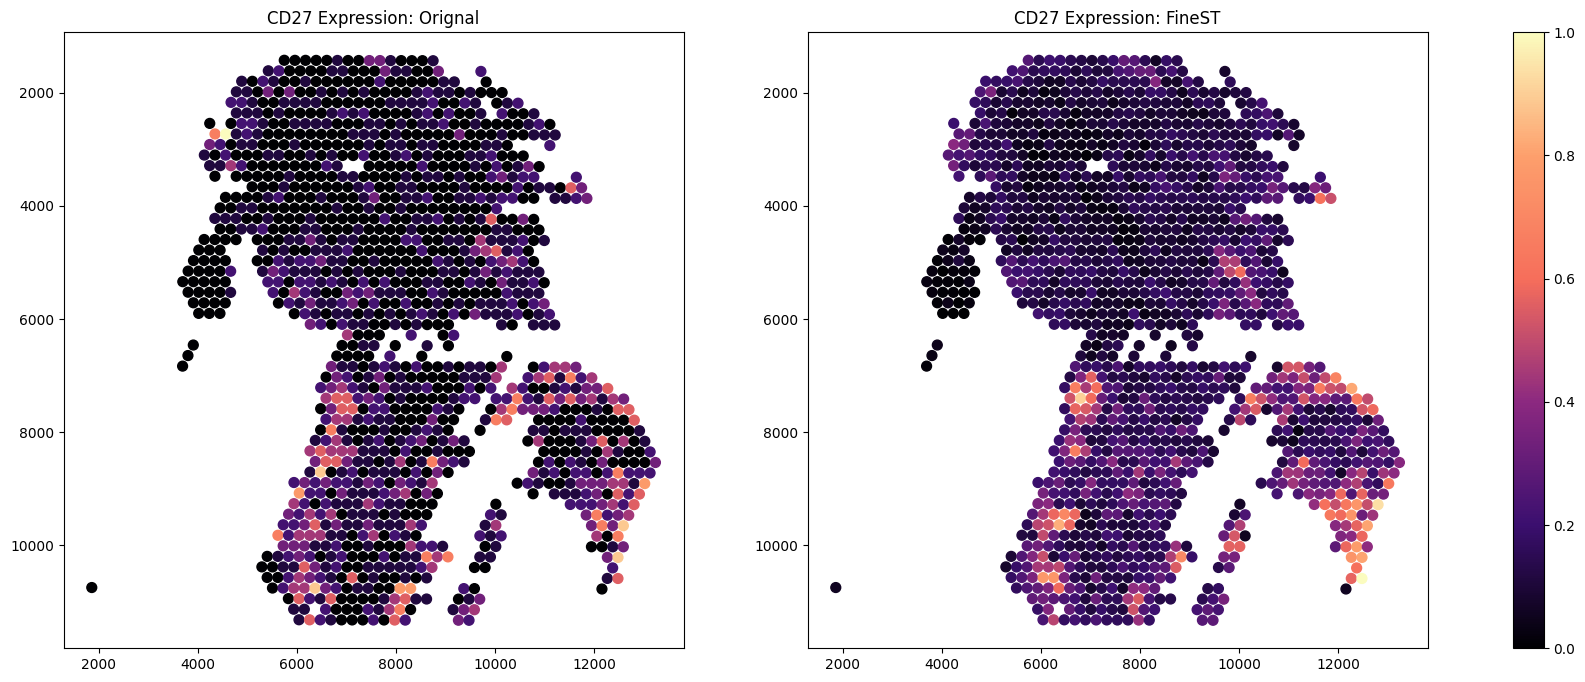

In [37]:
fstplt.gene_expr_compare(adata, "CD27", adata_infer_reshape, gene_hv, s=50, save_path=None)

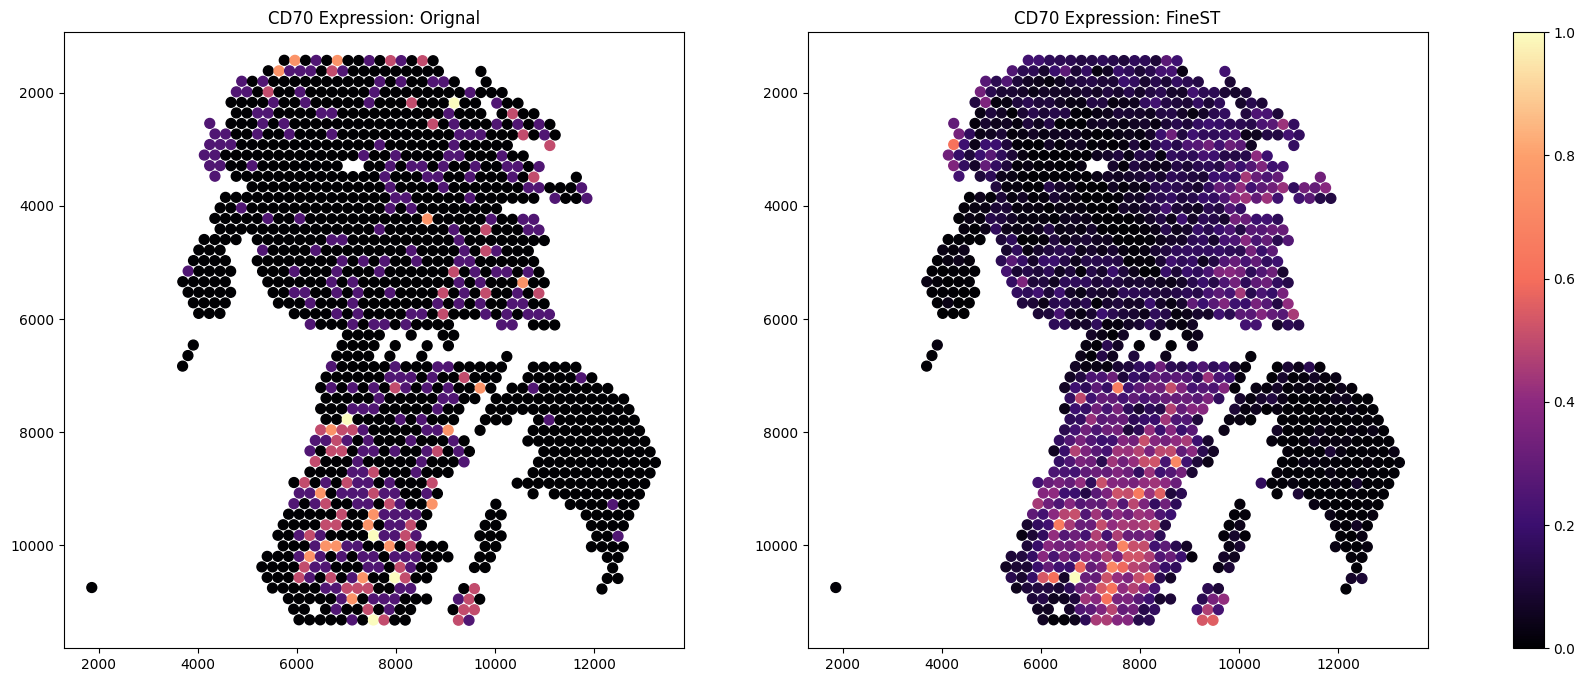

In [38]:
fstplt.gene_expr_compare(adata, "CD70", adata_infer_reshape, gene_hv, s=50, save_path=None)

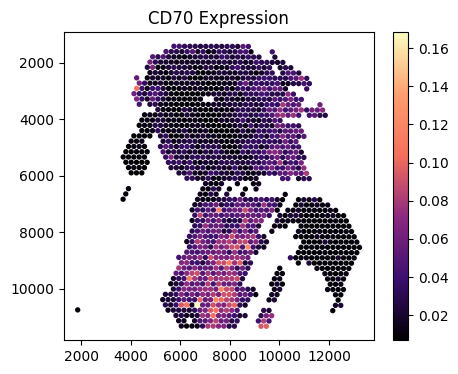

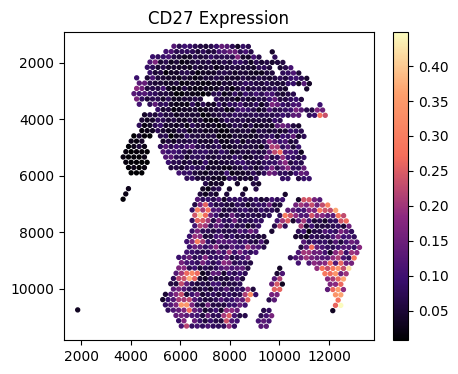

In [39]:
fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_infer_spot_within.pdf')

fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='CD27', marker='o', 
                 s=8, figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_infer_spot_within.pdf')

0.9187246744478581
0.3232017168168055


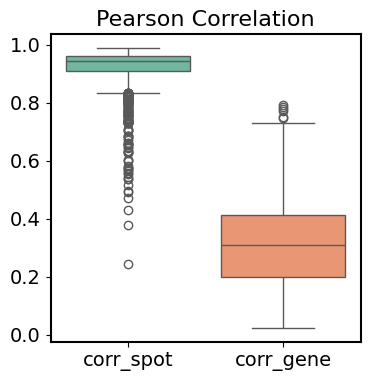

0.7059898681822363
0.19733976792096064


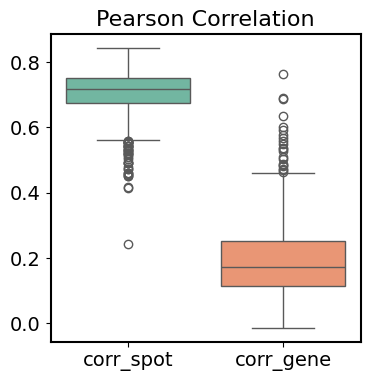

In [41]:
fstplt.mean_cor_box(adata, adata_infer_reshape, save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/Boxplot_infer_cor_count.pdf')
fstplt.mean_cor_box(adata_norma, adata_infer_reshape, save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/Boxplot_infer_cor_norml.pdf')

In [42]:
adata_infer_spot = fst.reshape2adata(adata, adata_infer_reshape, gene_hv)
adata_infer_spot.to_df()

TGFB1    TGFBR1    TGFBR2     TGFB2     TGFB3  \
GTCGTTATTCGCTTAT-1  0.070479  0.065111  0.005960  0.008080  0.014663   
ACAAGGGCAGGCTCTG-1  0.055559  0.064035  0.005332  0.007170  0.009131   
TGCGTTTGTTGACACT-1  0.020175  0.023029  0.002493  0.013827  0.011487   
TTGAATATGGACTTTC-1  0.057624  0.059739  0.006285  0.006221  0.008762   
CCGGGCGGTCTCGTCA-1  0.043464  0.036593  0.003685  0.015271  0.015887   
...                      ...       ...       ...       ...       ...   
CCTCTGGCCTAGACGG-1  0.048601  0.026315  0.003997  0.006387  0.019459   
CAAACTATTGAGCTTC-1  0.076399  0.041069  0.006192  0.009162  0.045636   
ACATCGTTAACCTAGT-1  0.027980  0.017613  0.002358  0.006635  0.016438   
GTTAGAGTGTGCCGCT-1  0.035267  0.023067  0.002651  0.008036  0.018992   
TCAGTTACGGAATGAT-1  0.020660  0.018057  0.002436  0.006672  0.014508   

                      ACVR1B    ACVR1C     ACVR1      BMP2    BMPR1A  ...  \
GTCGTTATTCGCTTAT-1  0.012900  0.010192  0.007711  0.011591  0.010386  ...   
ACAAGGGCAGGCTCTG-1  0.011158  0.014507  0.007190  0.010969  0.009194  ...   
TGCGTTTGTTGACACT-1  0.013835  0.003470  0.006674  0.009269  0.008095  ...   
TTGAATATGGACTTTC-1  0.009906  0.017859  0.007270  0.009795  0.008110  ...   
CCGGGCGGTCTCGTCA-1  0.028117  0.004523  0.007858  0.019688  0.010361  ...   
...                      ...       ...       ...       ...       ...  ...   
CCTCTGGCCTAGACGG-1  0.035849  0.006866  0.010139  0.037018  0.015693  ...   
CAAACTATTGAGCTTC-1  0.021276  0.013318  0.018880  0.010563  0.019940  ...   
ACATCGTTAACCTAGT-1  0.047091  0.003686  0.008758  0.020853  0.014615  ...   
GTTAGAGTGTGCCGCT-1  0.061552  0.003890  0.015950  0.023966  0.018518  ...   
TCAGTTACGGAATGAT-1  0.030329  0.003856  0.009602  0.028624  0.011963  ...   

                         KDR     TREM2    SEMA6A    SEMA6B    SEMA7A  \
GTCGTTATTCGCTTAT-1  0.007710  0.008343  0.013257  0.008921  0.070894   
ACAAGGGCAGGCTCTG-1  0.008098  0.007068  0.015103  0.008238  0.056089   
TGCGTTTGTTGACACT-1  0.007382  0.006471  0.013568  0.008581  0.011422   
TTGAATATGGACTTTC-1  0.006740  0.007039  0.013335  0.010835  0.052758   
CCGGGCGGTCTCGTCA-1  0.008515  0.007677  0.033669  0.009954  0.025186   
...                      ...       ...       ...       ...       ...   
CCTCTGGCCTAGACGG-1  0.006917  0.020449  0.030293  0.008972  0.021415   
CAAACTATTGAGCTTC-1  0.025597  0.033075  0.009769  0.043442  0.026782   
ACATCGTTAACCTAGT-1  0.007787  0.013308  0.026949  0.007291  0.011979   
GTTAGAGTGTGCCGCT-1  0.006722  0.027262  0.043090  0.010897  0.012046   
TCAGTTACGGAATGAT-1  0.009882  0.013017  0.053507  0.010573  0.010287   

                      PLXNC1   SIGLEC1      THY1     VCAM1      VSIR  
GTCGTTATTCGCTTAT-1  0.006469  0.007034  0.078036  0.201553  0.108820  
ACAAGGGCAGGCTCTG-1  0.006098  0.006554  0.074240  0.197712  0.086143  
TGCGTTTGTTGACACT-1  0.003780  0.005172  0.023047  0.069854  0.032721  
TTGAATATGGACTTTC-1  0.006136  0.006682  0.081259  0.172301  0.088905  
CCGGGCGGTCTCGTCA-1  0.005023  0.006136  0.039115  0.151711  0.059231  
...                      ...       ...       ...       ...       ...  
CCTCTGGCCTAGACGG-1  0.004928  0.006449  0.064543  0.230719  0.076784  
CAAACTATTGAGCTTC-1  0.005115  0.006769  0.122619  0.091330  0.103351  
ACATCGTTAACCTAGT-1  0.003698  0.005207  0.036605  0.148749  0.053497  
GTTAGAGTGTGCCGCT-1  0.004015  0.005580  0.034746  0.197110  0.064069  
TCAGTTACGGAATGAT-1  0.003896  0.005206  0.054870  0.220561  0.041019  

[1331 rows x 596 columns]

0.3232017168168055


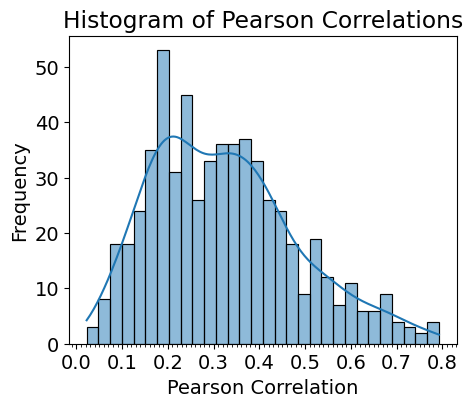

In [43]:
fstplt.cor_hist(adata, adata_infer_spot.to_df(), 
                 fig_size=(5, 4), trans=False, format='svg', 
                 save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/Hist_infer_cor_count.svg')

In [44]:
print(adata_infer)
print(adata_infer_spot)

AnnData object with n_obs × n_vars = 85184 × 596
    obs: 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [45]:
## save adata 85184 × 596
patientxy = 'patient1'
adata_infer.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_infer.h5ad')

In [46]:
## save adata 1331 × 596
patientxy = 'patient1'
adata_infer_spot.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_infer_spot.h5ad')

3.3 Impute the gene expression of sub-spots

Input: two input files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Input: three input files: \
    - `sudo_adata`: Imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here ` w=0.5`).\
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [47]:
adata_smooth = fst.impute_adata(adata, adata_infer, C2, gene_hv, 
                               dataset_class='Visium64', weight_exponent=2)
print(adata_smooth)

--- 19.143847227096558 seconds ---
AnnData object with n_obs × n_vars = 85184 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [48]:
adata_imput, data_impt = fst.weight_adata(adata_infer, adata_smooth, gene_hv, w=0.5)
print(data_impt)
print(adata_imput)

tensor([[1.2731e-01, 7.9132e-02, 2.4523e-01,  ..., 3.7658e-01, 1.6196e-01,
         2.6105e-01],
        [1.0755e-01, 6.6149e-02, 1.9133e-01,  ..., 3.9708e-01, 1.1573e-01,
         2.1433e-01],
        [9.0815e-02, 5.5184e-02, 1.4807e-01,  ..., 4.2161e-01, 1.0641e-01,
         1.5473e-01],
        ...,
        [3.9442e-01, 2.3131e-02, 1.0631e-03,  ..., 4.9547e-02, 1.4451e+00,
         2.7810e-02],
        [3.6895e-01, 2.4091e-02, 9.9086e-04,  ..., 5.4888e-02, 1.4006e+00,
         3.0374e-02],
        [3.3570e-01, 2.5787e-02, 6.2820e-04,  ..., 6.2924e-02, 1.5186e+00,
         3.3507e-02]], dtype=torch.float64)
AnnData object with n_obs × n_vars = 85184 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [49]:
print(adata_imput.obs[['x', 'y']])
print(adata_imput.obsm['spatial'])
print(adata_imput.obsm['spatial'][:,0].max(), adata_imput.obsm['spatial'][:,1].max())

           x     y
0       9965  9974
1       9979  9974
2       9993  9974
3      10007  9974
4      10021  9974
...      ...   ...
85179   9920  2046
85180   9934  2046
85181   9948  2046
85182   9962  2046
85183   9976  2046

[85184 rows x 2 columns]
[[9965 9974]
 [9979 9974]
 [9993 9974]
 ...
 [9948 2046]
 [9962 2046]
 [9976 2046]]
13285 11377


In [50]:
# print(adata_imput.obs[['x', 'y']])
# print(adata_imput.obsm['spatial'])
# print(adata_imput.obsm['spatial'][:,0].max(), adata_imput.obsm['spatial'][:,1].max())

In [51]:
adata_imput.to_df()

TGFB1    TGFBR1    TGFBR2     TGFB2     TGFB3    ACVR1B    ACVR1C  \
0      0.127311  0.079132  0.245231  0.002636  0.092744  0.004504  0.003186   
1      0.107546  0.066149  0.191332  0.002869  0.072457  0.004482  0.003394   
2      0.090815  0.055184  0.148071  0.002866  0.057006  0.004598  0.002772   
3      0.081448  0.048527  0.121248  0.002803  0.047647  0.004586  0.002747   
4      0.081663  0.046972  0.111287  0.002594  0.044255  0.004283  0.003358   
...         ...       ...       ...       ...       ...       ...       ...   
85179  0.410217  0.026106  0.001156  0.003252  0.004711  0.033123  0.002149   
85180  0.409142  0.023835  0.001163  0.003598  0.004624  0.062935  0.002077   
85181  0.394425  0.023131  0.001063  0.002983  0.004635  0.023682  0.002055   
85182  0.368952  0.024091  0.000991  0.002807  0.004492  0.024606  0.001952   
85183  0.335700  0.025787  0.000628  0.002969  0.004035  0.035612  0.001460   

          ACVR1      BMP2    BMPR1A  ...       KDR     TREM2    SEMA6A  \
0      0.003217  0.003842  0.028522  ...  0.132548  0.003226  0.004398   
1      0.003513  0.003980  0.024353  ...  0.105176  0.003528  0.004344   
2      0.003281  0.004132  0.020573  ...  0.082724  0.003691  0.004631   
3      0.003224  0.004209  0.018359  ...  0.068406  0.003607  0.004664   
4      0.003444  0.003687  0.017926  ...  0.062781  0.003132  0.004110   
...         ...       ...       ...  ...       ...       ...       ...   
85179  0.401893  0.004497  0.003817  ...  0.003023  0.004895  0.456487   
85180  0.400440  0.038243  0.004026  ...  0.003120  0.004593  0.536524   
85181  0.383889  0.004198  0.003617  ...  0.002778  0.004780  0.458921   
85182  0.355603  0.003958  0.003441  ...  0.002656  0.004553  0.455584   
85183  0.319081  0.012310  0.003234  ...  0.002230  0.003832  0.491824   

         SEMA6B    SEMA7A    PLXNC1   SIGLEC1      THY1     VCAM1      VSIR  
0      0.069026  0.317642  0.002692  0.003083  0.376577  0.161963  0.261052  
1      0.055297  0.354172  0.002882  0.003339  0.397077  0.115725  0.214326  
2      0.043958  0.382021  0.002423  0.003050  0.421609  0.106409  0.154734  
3      0.036713  0.398508  0.002404  0.002976  0.436860  0.109056  0.129338  
4      0.034005  0.401954  0.002900  0.003263  0.442691  0.080269  0.142878  
...         ...       ...       ...       ...       ...       ...       ...  
85179  0.004194  0.003611  0.001847  0.002729  0.077258  1.489935  0.029859  
85180  0.003947  0.003824  0.002087  0.002713  0.113190  1.646241  0.066127  
85181  0.004028  0.003517  0.001692  0.002604  0.049547  1.445120  0.027810  
85182  0.003972  0.003410  0.001600  0.002497  0.054888  1.400581  0.030374  
85183  0.003432  0.003063  0.001428  0.002098  0.062924  1.518594  0.033507  

[85184 rows x 596 columns]

For performance evaluation, we integrate super-resolved gene expression `data_impt` into spot-level gene expression `data_impt_reshape` (i.e., from 16x sub-spot level to spot level)

In [52]:
_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='Visium64')
print("data_impt shape:", data_impt.shape)
print("data_impt_reshape shape:", data_impt_reshape.shape)

data_impt shape: torch.Size([85184, 596])
data_impt_reshape shape: torch.Size([1331, 596])


3.4 Visualization: selected gene (Original vs. FineST)

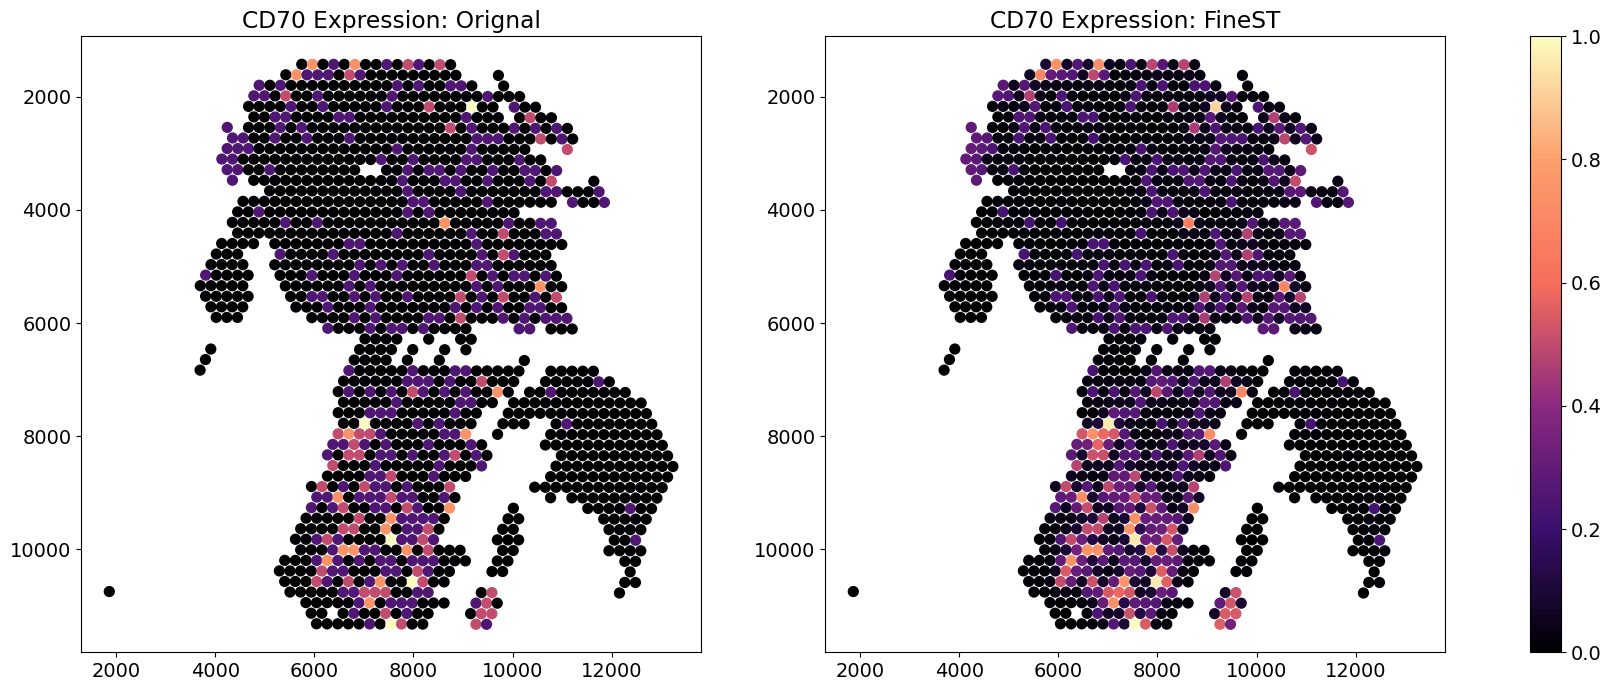

In [53]:
fstplt.gene_expr_compare(adata, "CD70", data_impt_reshape, gene_hv, s=50, save_path=None)

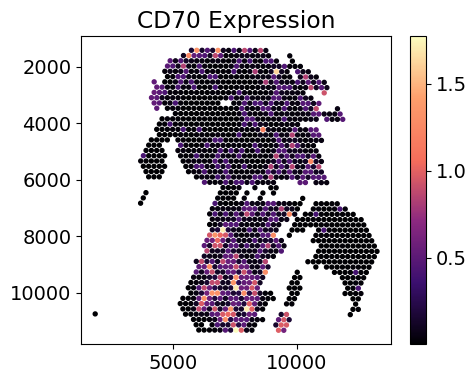

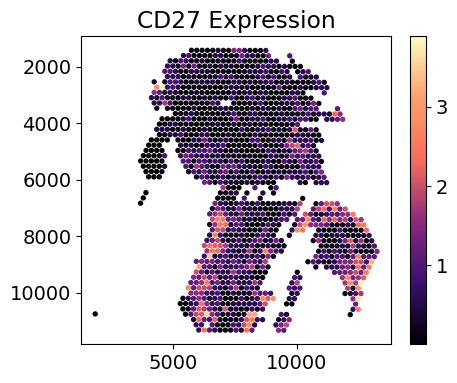

In [54]:
fstplt.gene_expr(adata, data_impt_reshape, gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_imput_spot_within.pdf')

fstplt.gene_expr(adata, data_impt_reshape, gene_selet='CD27', marker='o', 
                 s=8, figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_imput_spot_within.pdf')

3.4 Correlation: Selected gene、all spots and all genes、mean correlation box

The correlation can be used as a measure to evaluate the gene expression prediction performance. Here we provide three functions: \
    - `sele_gene_cor`: show the selected gene correlation (Reconstructed by FineST vs. Original). \
    - `mean_cor`     : calculate the mean correlation of all spots or all genes. \
    - `mean_cor_box` : box plot of correlation for all spots or all genes.

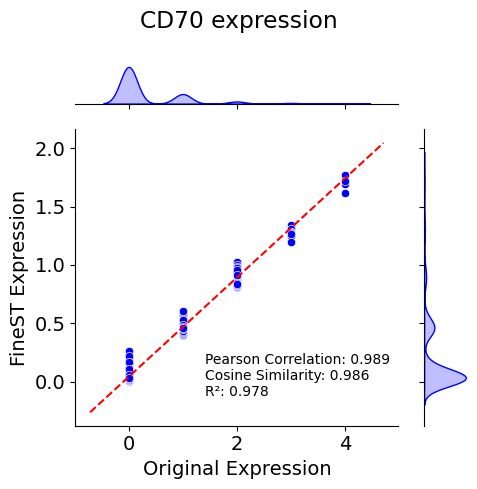

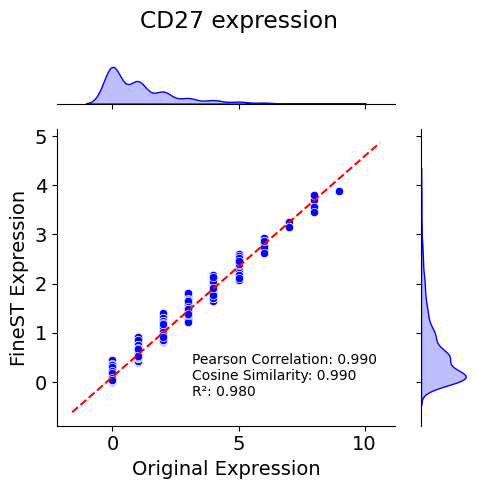

In [56]:
## if ones wants to save the figure in .pdf format, just set: save_path=str(gene)+'correlation.pdf'
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "CD70", 
                     ylabel='FineST Expression', title = "CD70 expression", size=5, 
                     save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_cor_imput_spot_within.pdf') 
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "CD27", 
                     ylabel='FineST Expression', title = "CD27 expression", size=5, 
                     save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_cor_imput_spot_within.pdf') 

In [57]:
logger.info("Running Gene Correlation task...")

(pearson_cor_gene, 
 spearman_cor_gene, 
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")

logger.info("Running Gene Correlation task DINE!")

[2025-02-10 18:34:46] INFO - Running Gene Correlation task...


matrix1:  (1331, 596)
matrix2:  (1331, 596)
Mean Pearson correlation coefficient--reconf2: 0.9907


[2025-02-10 18:34:46] INFO - Running Gene Correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.5617
Mean cosine similarity--reconf2: 0.9879


0.9911548893581774
0.9906692999037703


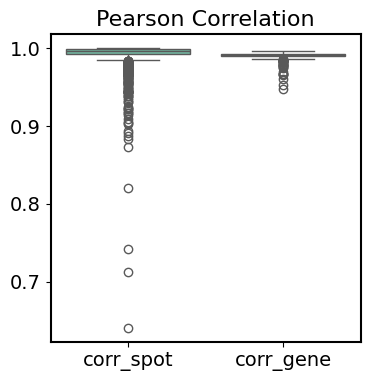

In [59]:
fstplt.mean_cor_box(adata, data_impt_reshape, save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/Boxplot_imput_cor_count.pdf')

In [60]:
adata_imput_spot = fst.reshape2adata(adata, data_impt_reshape, gene_hv)
adata_imput_spot.to_df()

TGFB1    TGFBR1    TGFBR2     TGFB2     TGFB3  \
GTCGTTATTCGCTTAT-1  0.090017  0.087660  0.075501  0.004040  0.049641   
ACAAGGGCAGGCTCTG-1  2.126571  0.878733  0.884529  0.003585  0.027835   
TGCGTTTGTTGACACT-1  0.054132  0.048756  0.477555  0.006914  0.010499   
TTGAATATGGACTTTC-1  0.577580  0.487541  0.905654  0.003111  0.419451   
CCGGGCGGTCTCGTCA-1  0.081905  0.024171  0.135263  0.007636  0.007944   
...                      ...       ...       ...       ...       ...   
CCTCTGGCCTAGACGG-1  0.075881  0.064904  0.019185  0.003194  0.009730   
CAAACTATTGAGCTTC-1  0.451972  0.072262  0.020281  0.004581  0.022818   
ACATCGTTAACCTAGT-1  0.445215  0.026145  0.018288  0.003317  0.008219   
GTTAGAGTGTGCCGCT-1  0.034825  0.046110  0.018517  0.004018  0.026649   
TCAGTTACGGAATGAT-1  0.431151  0.027470  0.001218  0.003336  0.007254   

                      ACVR1B    ACVR1C     ACVR1      BMP2    BMPR1A  ...  \
GTCGTTATTCGCTTAT-1  0.006450  0.005096  0.003855  0.005795  0.023561  ...   
ACAAGGGCAGGCTCTG-1  0.005579  0.007253  0.039302  0.411135  0.004597  ...   
TGCGTTTGTTGACACT-1  0.450741  0.001735  0.042943  0.011000  0.004048  ...   
TTGAATATGGACTTTC-1  0.023100  0.008930  0.418706  0.004898  0.419126  ...   
CCGGGCGGTCTCGTCA-1  0.032397  0.020619  0.003929  0.009844  0.005181  ...   
...                      ...       ...       ...       ...       ...  ...   
CCTCTGGCCTAGACGG-1  0.414428  0.003433  0.005070  0.018509  0.059405  ...   
CAAACTATTGAGCTTC-1  0.424457  0.006659  0.043958  0.005281  0.027220  ...   
ACATCGTTAACCTAGT-1  0.023545  0.001843  0.004379  0.010426  0.421112  ...   
GTTAGAGTGTGCCGCT-1  0.065250  0.001945  0.025128  0.011983  0.026533  ...   
TCAGTTACGGAATGAT-1  0.033606  0.001928  0.419753  0.014312  0.005981  ...   

                         KDR     TREM2    SEMA6A    SEMA6B    SEMA7A  \
GTCGTTATTCGCTTAT-1  0.040142  0.004171  0.006629  0.022604  0.456728   
ACAAGGGCAGGCTCTG-1  0.039202  0.003534  0.025427  0.427346  0.468861   
TGCGTTTGTTGACACT-1  0.003691  0.003236  0.026637  0.010656  0.021589   
TTGAATATGGACTTTC-1  0.040120  0.003520  0.024942  0.005418  0.178773   
CCGGGCGGTCTCGTCA-1  0.022503  0.003839  0.053693  0.004977  0.128350   
...                      ...       ...       ...       ...       ...   
CCTCTGGCCTAGACGG-1  0.003458  0.027411  0.480685  0.004486  0.028021   
CAAACTATTGAGCTTC-1  0.012799  0.413043  0.004884  0.021721  0.047852   
ACATCGTTAACCTAGT-1  0.003893  0.006654  0.013474  0.003645  0.005989   
GTTAGAGTGTGCCGCT-1  0.003361  0.013631  0.849302  0.005449  0.023176   
TCAGTTACGGAATGAT-1  0.004941  0.006509  0.489976  0.005287  0.005144   

                      PLXNC1   SIGLEC1      THY1     VCAM1      VSIR  
GTCGTTATTCGCTTAT-1  0.003235  0.003517  0.491060  0.136956  0.133060  
ACAAGGGCAGGCTCTG-1  0.003049  0.003277  0.955011  2.162275  0.507139  
TGCGTTTGTTGACACT-1  0.001890  0.002586  0.096030  0.076267  0.022726  
TTGAATATGGACTTTC-1  0.119505  0.003341  1.035703  1.646132  0.141794  
CCGGGCGGTCTCGTCA-1  0.069303  0.003068  0.604930  0.768918  0.127106  
...                      ...       ...       ...       ...       ...  
CCTCTGGCCTAGACGG-1  0.002464  0.003224  0.118723  1.667575  0.486812  
CAAACTATTGAGCTTC-1  0.019890  0.020570  0.113075  0.114552  0.189629  
ACATCGTTAACCTAGT-1  0.001849  0.002603  0.449573  0.953787  0.940691  
GTTAGAGTGTGCCGCT-1  0.053858  0.002790  0.051781  1.477977  0.083608  
TCAGTTACGGAATGAT-1  0.001948  0.002603  0.063524  1.506095  0.044708  

[1331 rows x 596 columns]

In [61]:
print(adata_imput)
print(adata_imput_spot)

AnnData object with n_obs × n_vars = 85184 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [62]:
## save adata: 85184 × 596
patientxy = 'patient1'
adata_imput.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_imput.h5ad')

In [63]:
## save adata: 1331 × 596
patientxy = 'patient1'
adata_imput_spot.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_imput_spot.h5ad')

<div class="alert alert-info">

**Note**
Here the `adata_impt` is the imputed spot-level gene expression from FineST, it only contains the given 1331 within spots. The comparisons are based on the original adata `patient1_adata_orignal.h5ad` vs. FineST's predicted adata `patient1_adata.h5ad`.

</div>

## 4. Infer gene expression of "within spot" and "between spot" 

4.1 Get all spot coordinates (within spot & between spot) of image embeddings

Input: two input file pathways: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [64]:
## add coords for each .pth file
# file_paths_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/')
# file_paths_between_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/')
file_paths_spot = os.listdir(str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_112_14/')
file_paths_between_spot = os.listdir(str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/NEW_AH_Patient1_pth_64_16/')
print("file_paths_spot number: ", len(file_paths_spot))
print("file_paths_between_spot number:", len(file_paths_between_spot))
file_paths_all = file_paths_spot + file_paths_between_spot
print("file_paths_all number:", len(file_paths_all))

## Merge, sort and process file paths
# data_all = fst.get_image_coord_all(file_paths_all, dataset_class='Visium')
data_all = fst.get_image_coord_all(file_paths_all)
position_order_allspot = pd.DataFrame(data_all, columns=['pixel_y', 'pixel_x'])
position_order_allspot

file_paths_spot number:  1331
file_paths_between_spot number: 3708
file_paths_all number: 5039


pixel_y pixel_x
0     10014.5  9836.0
1       10014   10023
2     10015.5  9462.5
3       10015    9649
4       10016    9276
...       ...     ...
5034   9978.0  3023.5
5035   9978.5  2836.5
5036   9979.0  2650.0
5037   9980.0  2277.0
5038   9980.5  2090.5

[5039 rows x 2 columns]

In [65]:
print(adata.obsm['spatial'][:,0].max(), adata.obsm['spatial'][:,1].max())
print(adata_imput.obs['x'].max(), adata_imput.obs['x'].max())
print(position_order_allspot['pixel_y'].astype(float).max(), position_order_allspot['pixel_x'].astype(float).max())

13236 11328
13285 13285
13236.0 11328.0


In [66]:
## save all spots
position_order_allspot.to_csv(str(path)+"FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv", index=False, header=False)

<div class="alert alert-info">

**Note**
The above two cells for `section 4.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_all.csv` according to image pixel coordinates.

</div>

4.2 Load all spot image embeddings with their coordinates

Input: three input file pathway: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. \
    - `spatial_pos_path`: ordered all ST spot coordinates from above cell, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv`

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [67]:
import glob
# file_paths_spot = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth'
# file_paths_between_spot = str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/*.pth'
file_paths_spot = str(path)+'FineST/FineST_local/Dataset/NPC/HIPT/AH_Patient1_pth_112_14/*.pth'
file_paths_between_spot = str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/NEW_AH_Patient1_pth_112_14/*.pth'
spatial_pos_path=str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_all.csv'

In [68]:
# dir_name = str(path)+'FineST/FineST_local/Finetune/20250206082837029647'

4.4 Load the trained model to infer all spots

In [69]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)

## load all spot (within and between) spots data
all_dataset = fst.build_loaders_inference_allimage(batch_size=len(file_paths_all), 
                                                   file_paths_spot=image_embed_path_NPC, 
                                                   file_paths_between_spot=file_paths_between_spot, 
                                                   spatial_pos_path=spatial_pos_path, 
                                                   dataset_class='Visium64')
## inference
logger.info("Running inference tesk between spot...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset, dataset_class='Visium64')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
# print("recon_ref_adata_image_f2:\n", recon_ref_adata_image_f2)
# print("input_coord_all:\n", input_coord_all)
logger.info("Running inference tesk between spot DONE!")

***** Building loaders_inference between spot *****


[2025-02-10 18:35:53] INFO - Running inference tesk between spot...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:2
***** Begin perform_inference: ******


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]

***** batch_size=adata.shape[0] *****
torch.Size([5039, 64, 1280])
1
***** *****
Finished extractting image_between_spot data



[2025-02-10 18:35:54] INFO - Running inference tesk between spot DONE!


--- 0.28057169914245605 seconds ---
recon_ref_adata_image_f2: (5039, 596)


4.5 Visualization all spots

In [70]:
## process_and_check_duplicates 0f the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10014.  10023. ]
 [10015.   9649. ]
 [10016.   9276. ]
 ...
 [ 9979.   2650. ]
 [ 9980.   2277. ]
 [ 9980.5  2090.5]]


CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.02039067]
 [0.01393374]
 [0.0099597 ]
 ...
 [0.02105246]
 [0.01623   ]
 [0.05425261]]


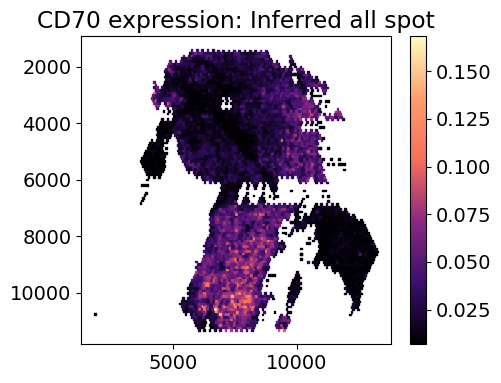

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.25781688]
 [0.21391232]
 [0.03726779]
 ...
 [0.04854828]
 [0.04807259]
 [0.07445253]]


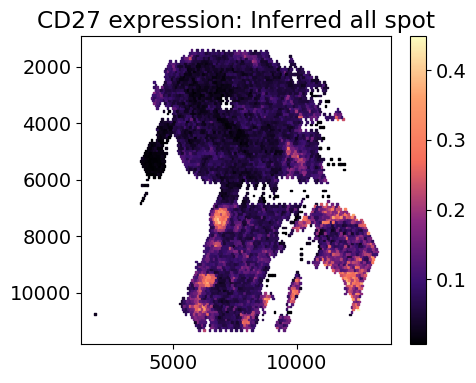

In [72]:
fstplt.gene_expr_allspots("CD70", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_infer_allspot.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_infer_allspot.pdf')

4.6 Visualization all sub-spots

In [73]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([5039, 64, 596])


In [74]:
spatial_loc_all

array([[10014. , 10023. ],
       [10015. ,  9649. ],
       [10016. ,  9276. ],
       ...,
       [ 9979. ,  2650. ],
       [ 9980. ,  2277. ],
       [ 9980.5,  2090.5]])

In [75]:
adata.obsm['spatial']

array([[10014, 10023],
       [10015,  9649],
       [10016,  9276],
       ...,
       [ 9924,  3117],
       [ 9925,  2743],
       [ 9927,  1997]])

In [76]:
## Get the sub-spot level gene expression of all genes in all spots
(_, _, all_spot_all_variable, 
 C2, adata_infer_all) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_all, gene_hv, patch_size=112, dataset_class="Visium64")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer_all)

pixel_step (half of patch_size): 7.0
all_spot_all_variable shape: (322496, 596)
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    obsm: 'spatial'


CD70 gene expression dim: (322496, 1)
CD70 gene expression: 
 [[0.00901483]
 [0.00921305]
 [0.00938539]
 ...
 [0.00900684]
 [0.00859159]
 [0.00757763]]


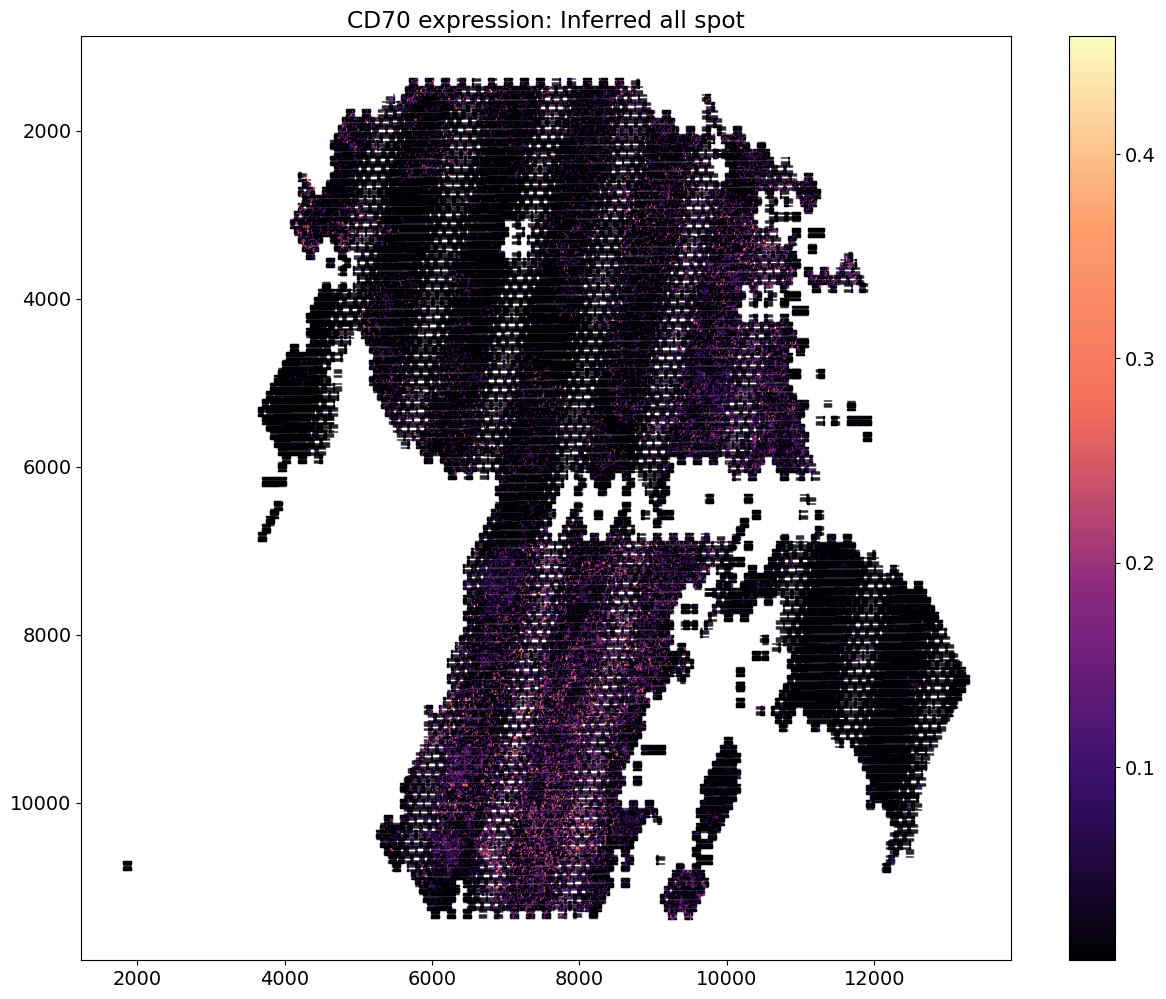

CD27 gene expression dim: (322496, 1)
CD27 gene expression: 
 [[0.21427067]
 [0.21880804]
 [0.12068177]
 ...
 [0.00898556]
 [0.00872154]
 [0.00792532]]


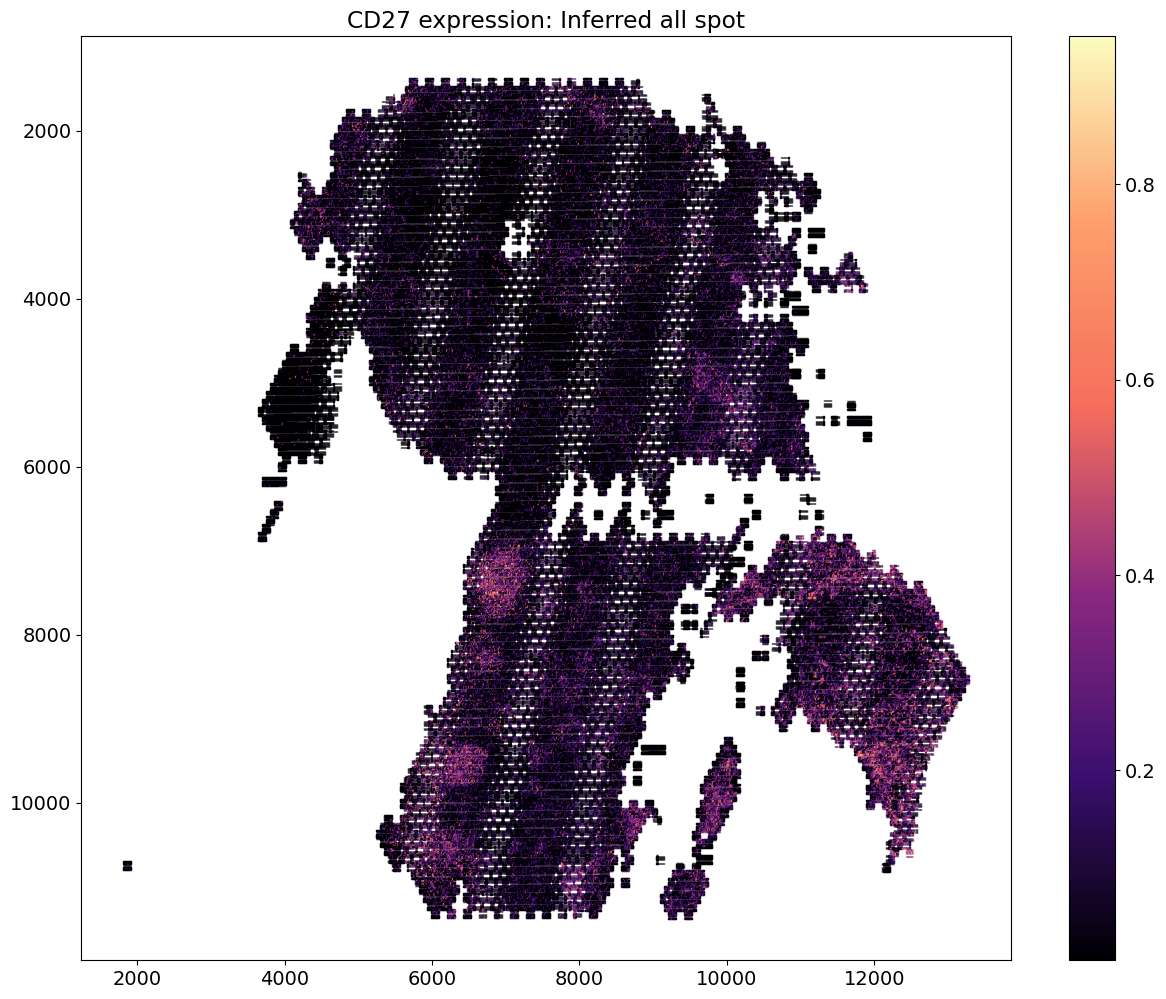

In [78]:
fstplt.gene_expr_allspots("CD70", C2, all_spot_all_variable, gene_hv, 
                           'Inferred all spot', marker='s', s=0.3, 
                          figsize=(15, 12), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_infer_allsubspot.pdf')
fstplt.gene_expr_allspots("CD27", C2, all_spot_all_variable, gene_hv, 
                           'Inferred all spot', marker='s', s=0.3, 
                          figsize=(15, 12), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_infer_allsubspot.pdf')

## 5. Imputate sub-spot gene expression using measured spot expression

5.1 Impute the gene expression of all sub-spots from all spots (within spots and between spots)

In [79]:
adata_smooth_all = fst.impute_adata(adata, adata_infer_all, C2, gene_hv, dataset_class='Visium64', weight_exponent=2)
print(adata_smooth_all)

--- 75.9802987575531 seconds ---
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [80]:
adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_smooth_all, gene_hv, w=0.5)  
print(data_impt_all)
print(adata_impt_all)

tensor([[0.1273, 0.0791, 0.2452,  ..., 0.3766, 0.1620, 0.2611],
        [0.1075, 0.0661, 0.1913,  ..., 0.3971, 0.1157, 0.2143],
        [0.0908, 0.0552, 0.1481,  ..., 0.4216, 0.1064, 0.1547],
        ...,
        [0.0898, 0.0045, 0.0094,  ..., 0.0229, 1.5218, 0.0112],
        [0.0724, 0.0042, 0.0074,  ..., 0.0210, 1.4754, 0.0101],
        [0.0630, 0.0036, 0.0058,  ..., 0.0203, 1.4770, 0.0093]],
       dtype=torch.float64)
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [78]:
# adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_smooth_all, gene_hv, w=0.5)  
# print(data_impt_all)
# print(adata_impt_all)

tensor([[4.0651e-01, 6.6373e-02, 7.8950e-01,  ..., 2.2649e-01, 3.6293e-01,
         7.4648e-01],
        [4.0109e-01, 6.9293e-02, 7.0319e-01,  ..., 2.6201e-01, 3.1715e-01,
         6.7182e-01],
        [2.5031e-01, 7.3122e-02, 5.2918e-01,  ..., 2.6154e-01, 1.5203e-01,
         5.3189e-01],
        ...,
        [8.9812e-03, 4.4631e-03, 1.4536e-03,  ..., 6.0265e-03, 1.5538e+00,
         5.1883e-03],
        [1.2761e-02, 4.1725e-03, 1.7711e-03,  ..., 7.5786e-03, 1.5010e+00,
         5.5421e-03],
        [6.2966e-02, 3.5671e-03, 5.1054e-03,  ..., 3.0883e-02, 1.4808e+00,
         1.1321e-02]], dtype=torch.float64)
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [81]:
# ## save aadata: 322496 × 596
patientxy = 'patient1'
adata_impt_all.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_imput_all_subspot.h5ad')

<div class="alert alert-info">

**Note**
Here, `adata_impt_all` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all.h5ad` contains about 1331x4x16 sub-spots. (1331 within spots, 1331x3 between spots, 16x resolution).

</div>

5.2 Convert super-resolved gene expression to spot-level and save the imputated spot-level adata

In [82]:
_, adata_impt_all_reshape = fst.reshape_latent_image(data_impt_all, dataset_class='Visium64')
print("data_impt_all shape:", adata_impt_all.shape)
print("adata_impt_all_reshape shape:", adata_impt_all_reshape.shape)

data_impt_all shape: (322496, 596)
adata_impt_all_reshape shape: torch.Size([5039, 596])


In [83]:
adata_impt_spot = fst.reshape2adata(adata, adata_impt_all_reshape, gene_hv, spatial_loc_all)
print("adata_impt_spot: ", adata_impt_spot)
print(adata_impt_spot.obsm['spatial'])

adata_impt_spot:  AnnData object with n_obs × n_vars = 5039 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
[[10014.  10023. ]
 [10015.   9649. ]
 [10016.   9276. ]
 ...
 [ 9979.   2650. ]
 [ 9980.   2277. ]
 [ 9980.5  2090.5]]


In [84]:
adata_impt_spot.to_df()

TGFB1    TGFBR1    TGFBR2     TGFB2     TGFB3    ACVR1B    ACVR1C  \
0     0.090017  0.087660  0.075501  0.004040  0.049641  0.006450  0.005096   
1     2.126571  0.878733  0.884529  0.003585  0.027835  0.005579  0.007253   
2     0.054132  0.048756  0.477555  0.006914  0.010499  0.450741  0.001735   
3     0.577580  0.487541  0.905654  0.003111  0.419451  0.023100  0.008930   
4     0.081905  0.024171  0.135263  0.007636  0.007944  0.032397  0.020619   
...        ...       ...       ...       ...       ...       ...       ...   
5034  0.255643  0.029286  0.179106  0.004265  0.018740  0.065224  0.001916   
5035  0.089030  0.036141  0.176685  0.005133  0.061423  0.113597  0.002118   
5036  0.026122  0.187264  0.019028  0.003833  0.059566  0.093516  0.001455   
5037  0.159293  0.010241  0.039648  0.002639  0.007653  0.122395  0.001097   
5038  0.244115  0.031864  0.008218  0.004041  0.007467  0.063284  0.001687   

         ACVR1      BMP2    BMPR1A  ...       KDR     TREM2    SEMA6A  \
0     0.003855  0.005795  0.023561  ...  0.040142  0.004171  0.006629   
1     0.039302  0.411135  0.004597  ...  0.039202  0.003534  0.025427   
2     0.042943  0.011000  0.004048  ...  0.003691  0.003236  0.026637   
3     0.418706  0.004898  0.419126  ...  0.040120  0.003520  0.024942   
4     0.003929  0.009844  0.005181  ...  0.022503  0.003839  0.053693   
...        ...       ...       ...  ...       ...       ...       ...   
5034  0.018392  0.007714  0.193814  ...  0.003717  0.008836  0.034922   
5035  0.060276  0.005852  0.033967  ...  0.005113  0.016156  0.367347   
5036  0.057293  0.019073  0.058903  ...  0.002943  0.004954  0.571199   
5037  0.038753  0.096577  0.006323  ...  0.002992  0.002909  0.170063   
5038  0.192705  0.032135  0.008773  ...  0.002567  0.005030  0.370583   

        SEMA6B    SEMA7A    PLXNC1   SIGLEC1      THY1     VCAM1      VSIR  
0     0.022604  0.456728  0.003235  0.003517  0.491060  0.136956  0.133060  
1     0.427346  0.468861  0.003049  0.003277  0.955011  2.162275  0.507139  
2     0.010656  0.021589  0.001890  0.002586  0.096030  0.076267  0.022726  
3     0.005418  0.178773  0.119505  0.003341  1.035703  1.646132  0.141794  
4     0.004977  0.128350  0.069303  0.003068  0.604930  0.768918  0.127106  
...        ...       ...       ...       ...       ...       ...       ...  
5034  0.003669  0.021059  0.002194  0.002933  0.208070  0.766351  0.695225  
5035  0.005258  0.059591  0.035061  0.003044  0.090128  1.044685  0.336108  
5036  0.003876  0.057784  0.234238  0.002275  0.256215  1.234223  0.052140  
5037  0.003963  0.005231  0.005033  0.001937  0.052360  1.467637  0.038295  
5038  0.003470  0.006838  0.001983  0.002670  0.064606  1.506123  0.061067  

[5039 rows x 596 columns]

In [85]:
# # save adata: 5039 × 596
patientxy = 'patient1'
adata_impt_spot.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_imput_all_spot.h5ad')

<div class="alert alert-info">

**Note**
Here, `adata_impt_spot` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all_spot.h5ad` contains about 1331x4 spots. (1331 within spots, 1331x3 between spots), it is integrated from `patient1_adata_all.h5ad` using the `reshape_latent_image` function.

</div>

5.3 Visualization: gene at all spot

CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.01019533]
 [0.00696687]
 [0.00497985]
 ...
 [0.19043142]
 [0.30098981]
 [0.21987522]]


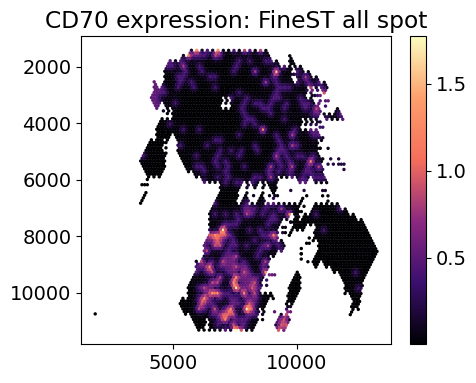

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.6349357 ]
 [1.86522224]
 [0.11362285]
 ...
 [0.12253295]
 [0.27639622]
 [0.09487489]]


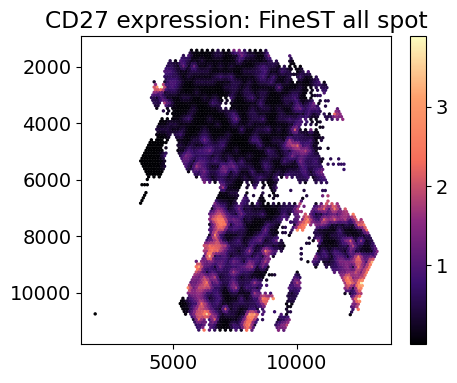

In [88]:
fstplt.gene_expr_allspots("CD70", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_imput_allspot.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_imput_allspot.pdf')

5.4 Visualization: gene at all sub-spot

CD70 gene expression dim: (322496, 1)
CD70 gene expression: 
 [[0.00450741]
 [0.00460653]
 [0.00469269]
 ...
 [0.39307488]
 [0.41272137]
 [0.42150204]]


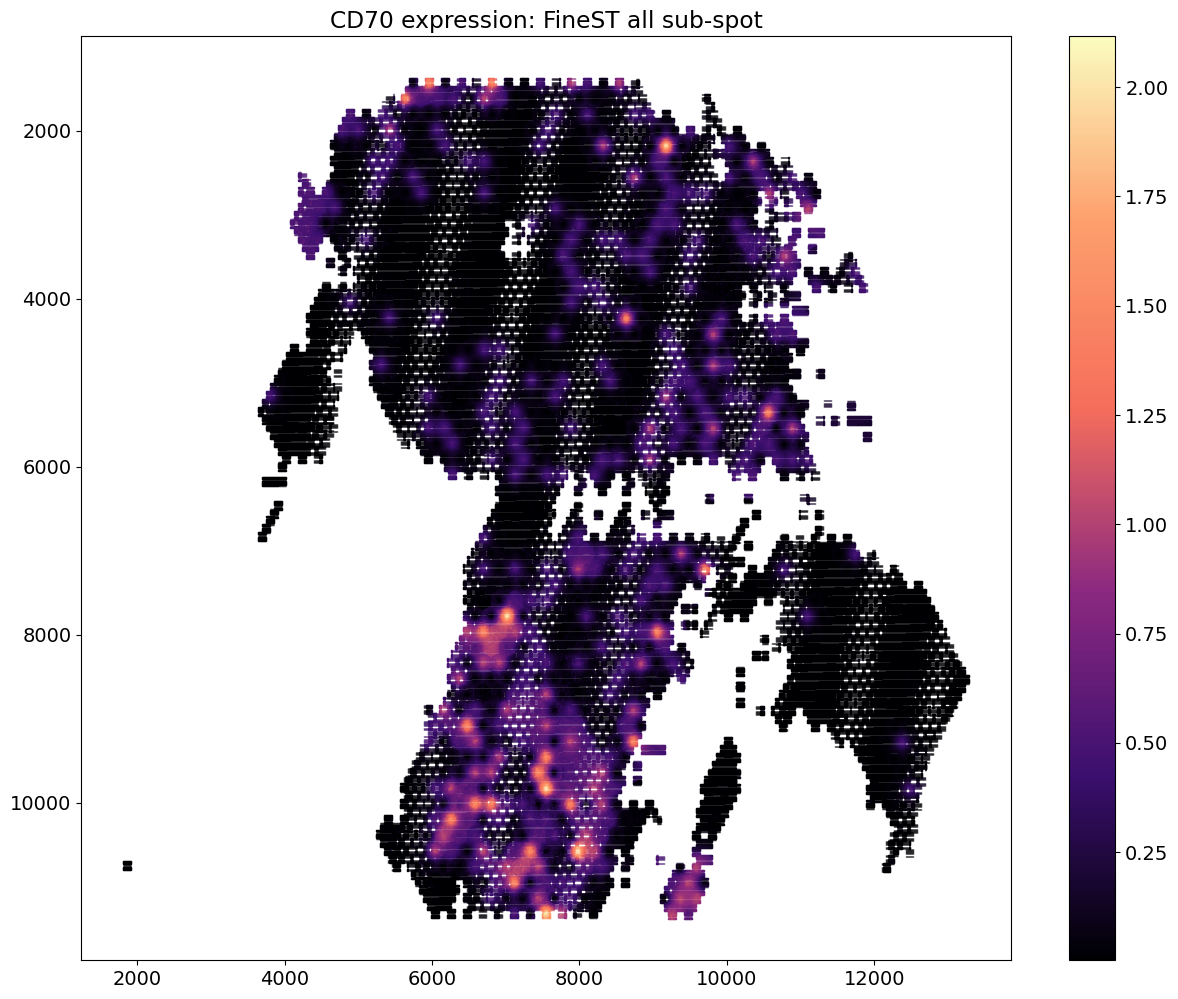

CD27 gene expression dim: (322496, 1)
CD27 gene expression: 
 [[0.60731662]
 [0.61732161]
 [0.5731491 ]
 ...
 [0.06345636]
 [0.05494229]
 [0.05127473]]


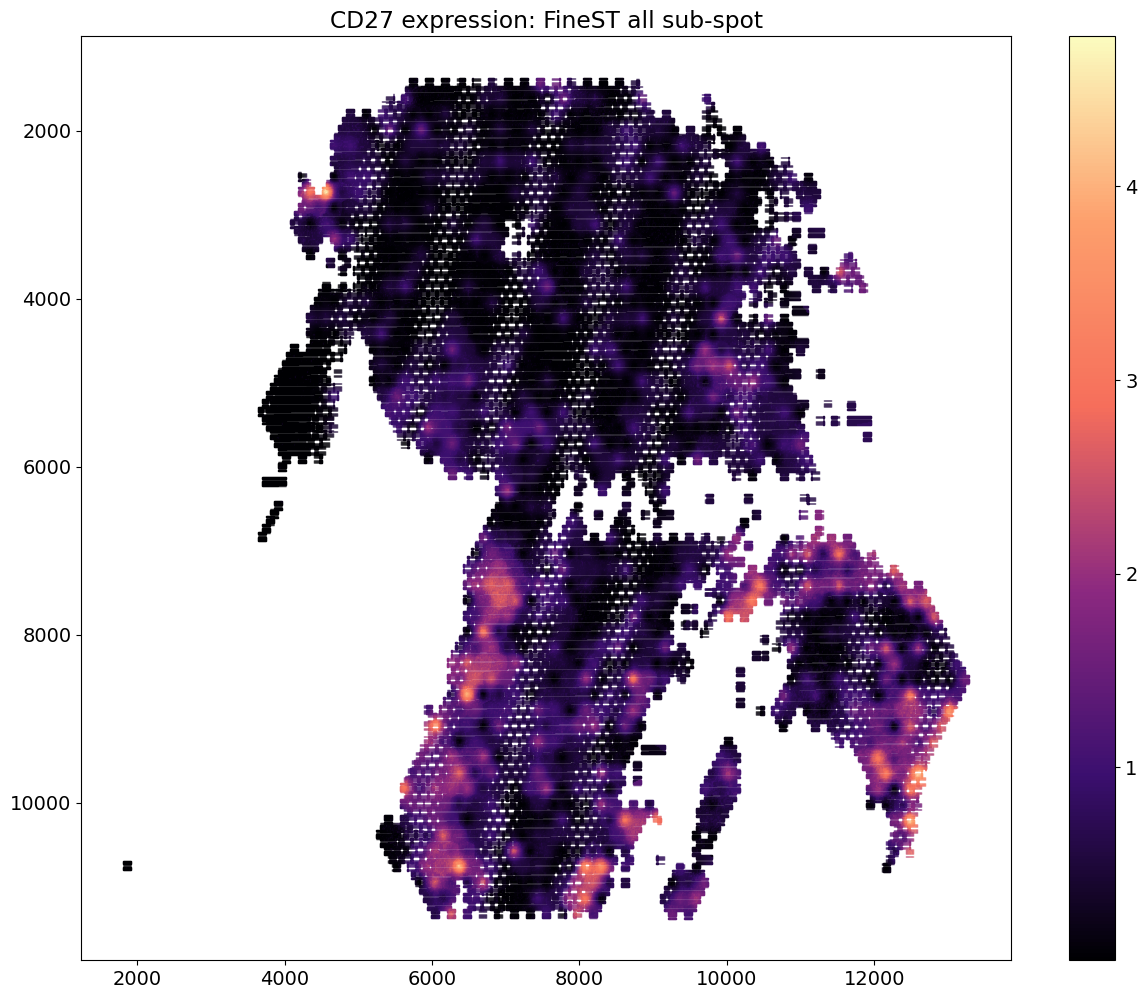

In [90]:
fstplt.gene_expr_allspots("CD70", C2, adata_impt_all.X, gene_hv, 
                          'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
                          save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_imput_allsubspot.pdf')
fstplt.gene_expr_allspots("CD27", C2, adata_impt_all.X, gene_hv, 
                          'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
                          save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_imput_allsubspot.pdf')

For NPC dataset, the the above four `` adata files can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

## 6. Infer and impute gene expression at "single-cell" level

<div class="alert alert-info">

**Note**
Section 6 directly infers super-resolved gene expression based on image features from ``nuclei segmentation``. The framework is similar to Section 3-5. 
</div>

6.1 Infer the gene expression of at single-cell resolution

In [89]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20250206082837029647'

You can use the `dir_name` just obtained from Section 2 (Model training), but just like Section 3, here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20250206082837029647`).

In [90]:
# dir_name = str(path)+'FineST/FineST_local/Finetune/20250206082837029647'  

The image embeddings feature `sc_Patient1_pth_14_14` is based on `_adata_imput_all_spot.adata` from the last section.

conda activate FineST

python ./FineST/FineST/demo/StarDist_nuclei_segmente.py \
        --tissue NPC1_allspot_p075_test \
        --out_dir ./FineST/FineST_local/Dataset/NPC/StarDist/DataOutput \
        --adata_path ./FineST/FineST_local/Dataset/ImputData/patient1/patient1_adata_imput_all_spot.h5ad \
        --img_path ./FineST/FineST_local/Dataset/NPC/patient1/20210809-C-AH4199551.tif \
        --prob_thresh 0.75

In [91]:
# file_paths_sc = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/sc_Patient1_pth_16_16/'))
file_paths_sc = sorted(os.listdir(str(path) + 'FineST/FineST_local/Dataset/NPC/HIPT/sc_Patient1_pth_14_14/'))
print("Image embedding file: \n", file_paths_sc[:3])

Image embedding file: 
 ['AH_Patient1_10000.0_9328.81908402034.pth', 'AH_Patient1_10000.0_9579.185992854487.pth', 'AH_Patient1_10000.34157012931_3421.0.pth']


In [92]:
## Image patch position
data_all_sc = fst.get_image_coord_all(file_paths_sc)
spatial_loc_sc = pd.DataFrame(data_all_sc, columns=['pixel_y', 'pixel_x'])
# spatial_loc_sc = spatial_loc_sc[['pixel_x', 'pixel_y']]
spatial_loc_sc

pixel_y             pixel_x
0                 10000.0    9328.81908402034
1                 10000.0   9579.185992854487
2       10000.34157012931              3421.0
3      10000.369812522753   5901.028213367254
4      10001.002772069014   4593.408879051549
...                   ...                 ...
40063   9998.037726836004   3565.071488896748
40064   9998.301841772049  4732.1525938561535
40065   9998.523219814242              4261.0
40066              9999.0    9944.09120972564
40067   9999.685735974588   3912.639990558908

[40068 rows x 2 columns]

In [93]:
# print(adata.obsm['spatial'][:,0].max(), adata.obsm['spatial'][:,1].max())
# print(adata_imput.obs['x'].max(), adata_imput.obs['x'].max())
# print(position_order_allspot['pixel_y'].astype(float).max(), position_order_allspot['pixel_x'].astype(float).max())

- 13236 11328 
- 13248 13248  
- 13236.0 11328.0

In [94]:
# print(position_order['pixel_y'].max(), position_order['pixel_x'].max())

13236 11328

In [95]:
print(spatial_loc_sc['pixel_y'].max(), spatial_loc_sc['pixel_x'].max())
print(spatial_loc_sc['pixel_y'].astype(float).max(), spatial_loc_sc['pixel_x'].astype(float).max())

9999.685735974588 9999.263061138892
13306.0 11398.0


In [96]:
len(file_paths_sc)

40068

In [97]:
## save .csv file
spatial_loc_sc.to_csv(str(path)+"FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_sc.csv", index=False, header=False)

Input: three input file pathway: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. \
    - `spatial_pos_path`: ordered all ST spot coordinates from above cell, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv`

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [98]:
import glob
# image_embed_path_sc = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/sc_Patient1_pth_16_16/*.pth'
image_embed_path_sc = str(path)+'FineST/FineST_local/Dataset/NPC/HIPT/sc_Patient1_pth_14_14/*.pth'
spatial_pos_path_sc=str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_sc.csv'

In [99]:
## load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)

## load all data
all_dataset_sc = fst.build_loaders_inference_allimage(batch_size=len(file_paths_sc),
                                                       file_paths_spot=image_embed_path_sc, 
                                                       spatial_pos_path=spatial_pos_path_sc, 
                                                       dataset_class='VisiumSC')

## inference
logger.info("Running inference tesk single-nuclei...")

start_time = time.time()

(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset_sc, dataset_class='VisiumSC')

print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
print("recon_ref_adata_image_f2:\n", recon_ref_adata_image_f2)
# print("input_coord_all:\n", input_coord_all)

logger.info("Running inference tesk single-nuclei DONE!")

***** Building loaders_inference sc image *****


[2025-02-10 18:42:43] INFO - Running inference tesk single-nuclei...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:2
***** Begin perform_inference: ******


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]
[2025-02-10 18:42:44] INFO - Running inference tesk single-nuclei DONE!


***** batch_size=adata.shape[0] *****
torch.Size([40068, 1, 1280])
1
***** *****
Finished extractting image_between_spot data
--- 1.815852165222168 seconds ---
recon_ref_adata_image_f2: (40068, 596)
recon_ref_adata_image_f2:
 [[0.3711783  0.22329916 0.00723031 ... 0.01965988 0.52262676 0.44857314]
 [0.4276653  0.30537632 0.00840155 ... 0.16924888 0.5803732  0.43954587]
 [0.32154092 0.20617627 0.00892711 ... 0.145621   0.44996816 0.37400392]
 ...
 [0.24538764 0.15729092 0.0080444  ... 0.18296216 0.3673103  0.264415  ]
 [0.36679474 0.22118105 0.00910317 ... 0.15563667 0.4084928  0.39634207]
 [0.38392952 0.24215238 0.00907456 ... 0.19000399 0.44996542 0.42106882]]


In [100]:
spatial_loc_sc = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_sc.shape)
spatial_loc_sc

Are there any duplicate rows? : False
(40068, 2)


array([[10000.        ,  9328.81908402],
       [10000.        ,  9579.18599285],
       [10000.34157013,  3421.        ],
       ...,
       [ 9998.52321981,  4261.        ],
       [ 9999.        ,  9944.09120973],
       [ 9999.68573597,  3912.63999056]])

In [101]:
print(spatial_loc_sc)

[[10000.          9328.81908402]
 [10000.          9579.18599285]
 [10000.34157013  3421.        ]
 ...
 [ 9998.52321981  4261.        ]
 [ 9999.          9944.09120973]
 [ 9999.68573597  3912.63999056]]


CD70 gene expression dim: (40068, 1)
CD70 gene expression: 
 [[0.31504917]
 [0.10513603]
 [0.17031382]
 ...
 [0.05051512]
 [0.13781841]
 [0.16591659]]


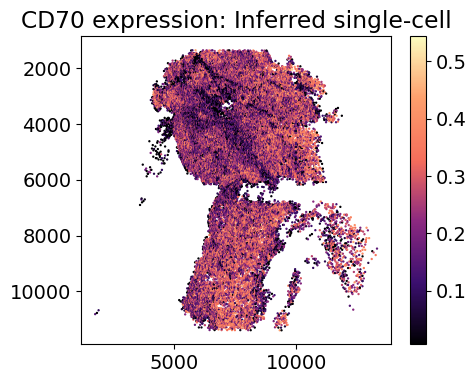

CD27 gene expression dim: (40068, 1)
CD27 gene expression: 
 [[0.4302557 ]
 [0.57453763]
 [0.44560125]
 ...
 [0.38134432]
 [0.49298233]
 [0.5108184 ]]


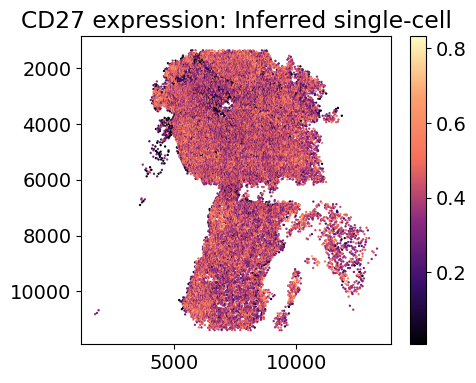

In [105]:
fstplt.gene_expr_allspots("CD70", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
                          'Inferred single-cell', s=0.6, 
                         figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_infer_allsc.pdf')

fstplt.gene_expr_allspots("CD27", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
                          'Inferred single-cell', s=0.6, 
                          figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_infer_allsc.pdf')

In [106]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='VisiumSC')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([40068, 1, 596])


In [107]:
(_, _, all_spot_all_variable, 
 C2, adata_infer_sc) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_sc, gene_hv, patch_size=14, dataset_class="VisiumSC")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer_sc)

pixel_step (half of patch_size): 7.0
all_spot_all_variable shape: (40068, 596)
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    obsm: 'spatial'


In [108]:
adata_smooth_sc = fst.impute_adata(adata, adata_infer_sc, C2, gene_hv, dataset_class='VisiumSC', weight_exponent=2)
print(adata_smooth_sc)

--- 9.22375750541687 seconds ---
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [109]:
adata_impt_sc, data_impt_sc = fst.weight_adata(adata_infer_sc, adata_smooth_sc, gene_hv, w=0.5)
print(data_impt_sc)
print(adata_impt_sc)

tensor([[0.2629, 0.1863, 0.4643,  ..., 0.1584, 0.3343, 0.2356],
        [1.7976, 0.8465, 0.7252,  ..., 0.9210, 1.8349, 0.5856],
        [0.3803, 0.2450, 0.0333,  ..., 0.1636, 0.4539, 0.7323],
        ...,
        [0.2044, 0.2240, 0.0248,  ..., 0.2945, 1.8214, 0.5505],
        [0.3544, 0.1759, 0.2975,  ..., 0.4286, 0.2787, 0.4919],
        [0.4997, 0.6458, 0.1557,  ..., 0.5064, 0.9868, 0.4826]],
       dtype=torch.float64)
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [110]:
_, adata_impt_sc_reshape = fst.reshape_latent_image(data_impt_sc, dataset_class='VisiumSC')
print("data_impt_sc shape:", adata_impt_sc.shape)
print("adata_impt_sc_reshape shape:", adata_impt_sc_reshape.shape)

data_impt_sc shape: (40068, 596)
adata_impt_sc_reshape shape: torch.Size([40068, 596])


CD70 gene expression dim: (40068, 1)
CD70 gene expression: 
 [[0.15752459]
 [0.05256801]
 [0.08515691]
 ...
 [0.33432216]
 [0.06890921]
 [0.0829583 ]]


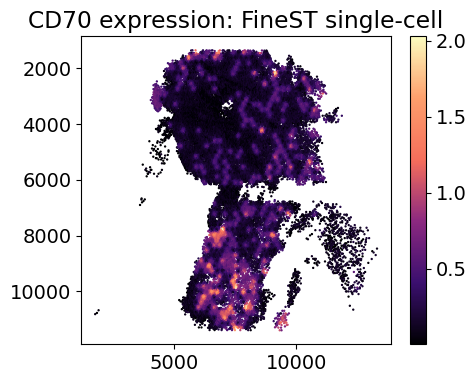

CD27 gene expression dim: (40068, 1)
CD27 gene expression: 
 [[0.39995208]
 [1.7709866 ]
 [1.08254839]
 ...
 [1.61611109]
 [0.78955756]
 [0.86492353]]


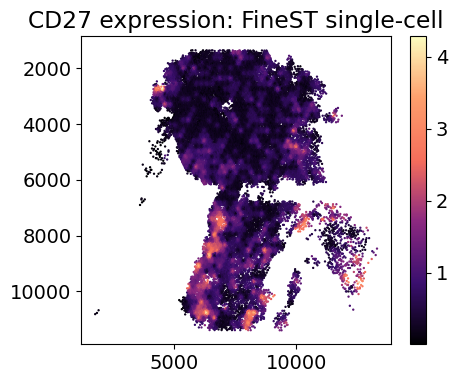

In [112]:
fstplt.gene_expr_allspots("CD70", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD70_expr_imput_allsc.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=str(path)+'FineST/FineST_local/Dataset/NPC/Figures/CD27_expr_imput_allsc.pdf')

<div class="alert alert-info">

**Note**
For NPC dataset, the the above four `` adata files can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).
</div>

In [113]:
## save adata: 40068 × 596
patientxy = 'patient1'
adata_impt_sc.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_imput_all_sc.h5ad')